# Milestone 2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

We start by loading the tables.

In [2]:
df_plot = pd.read_csv("data/MovieSummaries/plot_summaries.txt", sep='\t', header=None, names=["wikiID", "plot"])

df_meta = pd.read_csv("data/MovieSummaries/movie.metadata.tsv", sep='\t', header=None, 
    names=["wikiID", "freeID", "name", "release_date", "revenue", "runtime", "languages", "countries", "genres"])

df_char = pd.read_csv("data/MovieSummaries/character.metadata.tsv", sep='\t',header=None, 
    names=["WikiID", "freeID", "release_date", "char_name", "actor_DOB", "actor_gender", "actor_height", "actor_ethnicity",
           "actor_name", "Actor_age", "freeID_char_map", "FreeID_char", "FreeID_actor"])

df_char_names = pd.read_csv('data/MovieSummaries/name.clusters.txt', sep="\t", header=None, 
    names=["char_name", "freeID_char_map"])

df_tropes = pd.read_csv('data/MovieSummaries/tvtropes.clusters.txt', sep='\t', header=None, names=["trope", "details"])

## Data features and missing values

In [3]:
df_plot.head()

,wikiID,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [4]:
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42303 entries, 0 to 42302
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   wikiID  42303 non-null  int64 
 1   plot    42303 non-null  object
dtypes: int64(1), object(1)
memory usage: 661.1+ KB


In [5]:
df_meta.head()

,wikiID,freeID,name,release_date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [6]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wikiID        81741 non-null  int64  
 1   freeID        81741 non-null  object 
 2   name          81741 non-null  object 
 3   release_date  74839 non-null  object 
 4   revenue       8401 non-null   float64
 5   runtime       61291 non-null  float64
 6   languages     81741 non-null  object 
 7   countries     81741 non-null  object 
 8   genres        81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


Looking at the output above, we might think that the languages, countries and genres columns have no missing elements but actually some elements are just empty dictionary values

In [7]:
print(df_meta['languages'].value_counts()['{}'])
print(df_meta['countries'].value_counts()['{}'])
print(df_meta['genres'].value_counts()['{}'])

13866
8154
2294


Also, if we want to make use of the release date we can already convert it to datetime and check if we have more missing values.

In [8]:
df_meta['release_date'] = pd.to_datetime(df_meta['release_date'], errors = 'coerce')
print(df_meta['release_date'].shape[0] - df_meta['release_date'].isnull().sum())

74838


In [9]:
df_char.head()

,WikiID,freeID,release_date,char_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,Actor_age,freeID_char_map,FreeID_char,FreeID_actor
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [10]:
df_char.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   WikiID           450669 non-null  int64  
 1   freeID           450669 non-null  object 
 2   release_date     440674 non-null  object 
 3   char_name        192794 non-null  object 
 4   actor_DOB        344524 non-null  object 
 5   actor_gender     405060 non-null  object 
 6   actor_height     154824 non-null  float64
 7   actor_ethnicity  106058 non-null  object 
 8   actor_name       449441 non-null  object 
 9   Actor_age        292556 non-null  float64
 10  freeID_char_map  450669 non-null  object 
 11  FreeID_char      192804 non-null  object 
 12  FreeID_actor     449854 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 44.7+ MB


In [11]:
df_char_names.head()

,char_name,freeID_char_map
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


In [12]:
df_char_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   char_name        2666 non-null   object
 1   freeID_char_map  2666 non-null   object
dtypes: object(2)
memory usage: 41.8+ KB


In [13]:
df_tropes.head()

,trope,details
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richi..."
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The S..."
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!..."
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""..."


In [14]:
df_tropes = df_tropes.drop(["details"], axis=1).join(pd.json_normalize(df_tropes["details"].map(json.loads).tolist())).rename(
    columns={"id":"freeID_char_map"})

df_tropes.head()

,trope,char,movie,freeID_char_map,actor
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


In [15]:
df_tropes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   trope            501 non-null    object
 1   char             501 non-null    object
 2   movie            501 non-null    object
 3   freeID_char_map  501 non-null    object
 4   actor            501 non-null    object
dtypes: object(5)
memory usage: 19.7+ KB


---
## NLPCore

After we looked at the Stanford CoreNLP-processed summaries, we assumed it would not be useful for us.

The code below is an example where we load and parse the data to retrieve an element.

In [16]:
import gzip
import os
from bs4 import BeautifulSoup

path = "data/corenlp_plot_summaries/"
files = os.listdir(path)
print(files[0])
f = gzip.open(path+files[0], 'rb')

test = f.read().decode()
# print(test)

Bs_data = BeautifulSoup(test, "xml")
print(Bs_data.find("sentence", {'id':'20'}).find('NER').text)

FileNotFoundError: [Errno 2] No such file or directory: 'data/corenlp_plot_summaries/'

---
## Exploratory data analysis

### Genres, languages and countries

We want to identify the most represented genres, languages and countries.

In [17]:
def fcount(df):
    df2 = pd.DataFrame(data={
        'id': df.apply(lambda x: list(json.loads(x).keys())),
        'name': df.apply(lambda x: list(json.loads(x).values()))
    })
    
    distinctf = []
    counter = []

    for i in range(df2.shape[0]):
        fid = df2["id"].iloc[i]
        fname = df2["name"].iloc[i]
        for j in range(len(fid)):
            if [fid[j], fname[j]] not in distinctf:
                distinctf.append([fid[j], fname[j]])
                counter.append(1)
            else:
                counter[distinctf.index([fid[j], fname[j]])] += 1

    new = pd.DataFrame(data={
        'id': [s[0] for s in distinctf],
        'name': [s[1] for s in distinctf],
        'count': counter
    })
    
    return new.sort_values(by="count", ascending=False, ignore_index=True)

In [18]:
df_genre = fcount(df_meta["genres"])
df_genre.head(20)

,id,name,count
0,/m/07s9rl0,Drama,34007
1,/m/01z4y,Comedy,16349
2,/m/02l7c8,Romance Film,10234
3,/m/01g6gs,Black-and-white,9094
4,/m/02kdv5l,Action,8798
5,/m/01jfsb,Thriller,8744
6,/m/02hmvc,Short Film,8141
7,/m/03q4nz,World cinema,7155
8,/m/0lsxr,Crime Fiction,6948
9,/m/0219x_,Indie,6897


In [19]:
df_lang = fcount(df_meta["languages"])
df_lang.head(20)

,id,name,count
0,/m/02h40lc,English Language,40891
1,/m/03k50,Hindi Language,3744
2,/m/06nm1,Spanish Language,3673
3,/m/064_8sq,French Language,3422
4,/m/06ppq,Silent film,3183
5,/m/02bjrlw,Italian Language,2531
6,/m/03_9r,Japanese Language,2295
7,/m/04306rv,German Language,2258
8,/m/07c9s,Tamil Language,1896
9,/m/0999q,Malayalam Language,1448


In [20]:
df_country = fcount(df_meta["countries"])
df_country.head(20)

,id,name,count
0,/m/09c7w0,United States of America,34408
1,/m/03rk0,India,8411
2,/m/07ssc,United Kingdom,7868
3,/m/0f8l9c,France,4395
4,/m/03rjj,Italy,3163
5,/m/03_3d,Japan,2647
6,/m/0d060g,Canada,2534
7,/m/0345h,Germany,2393
8,/m/0jgd,Argentina,1468
9,/m/03h64,Hong Kong,1240


There might be a correlation between the country and language features.

### Release date distribution

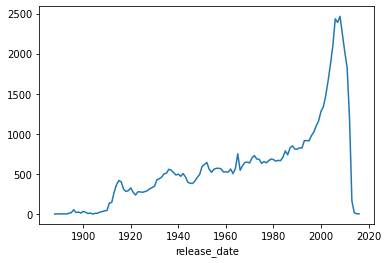

In [21]:
df_meta.groupby(df_meta["release_date"].dt.year).count()['wikiID'].plot()
plt.show()

We want to study the similarity between two movies so the date of their releases can be interesting. In this case, the exact release date might not be necessary, because it is expected that the difference would lie between movies that have for example 10 years of difference not just a few months. Actually, in some cases we only have the year of the release, so it might be simpler to only store the year of the release for all movies in order to keep homogeneous data.

### Runtime distribution

In [22]:
print(df_meta['runtime'].max())

1079281.0


2 years of runtime?

In [23]:
print(df_meta[df_meta['runtime'] >= 400].shape[0])
print(df_meta[df_meta['runtime'] <= 3].shape[0])

66
250


More than 6 hours of runtime seems too large and less than 3 minutes seems too short.

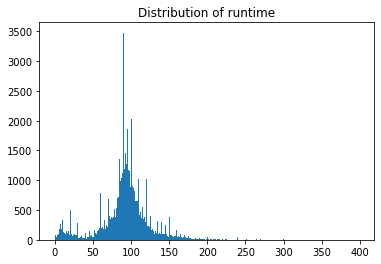

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(df_meta[df_meta['runtime'] < 400]['runtime'], bins=400)
ax.set_title('Distribution of runtime')

plt.show()

We can observe that the distribution is more concentrated around a runtime of 90 minutes but it appears there is a cluster around 20 which might corresponds to short films (6th most represented movie genre in the dataset).

The exact value of the runtime does not always seem to be reliable data, and looking at the distribution it might be a good idea to replace the runtime by an attribute like "short", "long" or "don't know" (if runtime is NaN).

### Runtime distribution

<AxesSubplot:>

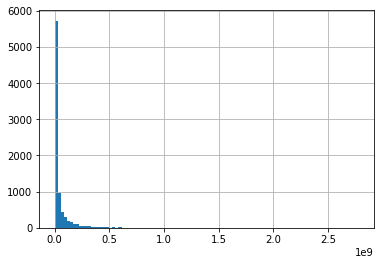

In [25]:
df_meta['revenue'].dropna().hist(bins=100)

In [26]:
print(df_meta['revenue'].max())

2782275172.0


In [27]:
print(df_meta[df_meta['revenue']==df_meta['revenue'].max()].name)

23702    Avatar
Name: name, dtype: object


There is a very large different between most of the movies and the movies that had a huge success such as "Avatar".

Note that the box office revenue is absent for most of the movies and we might not need it to compute the similarity between two movies. Therefore, we estimated that this feature would not be useful for our project.

### Distribution of the number of words per plot

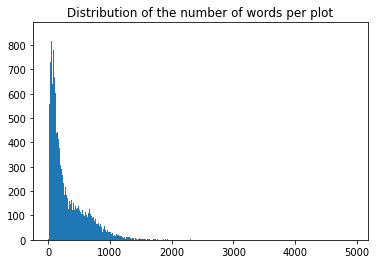

In [28]:
#use raw plot_summaries and count nb of words in each plot 
df_plot_fltr = df_plot.copy()
df_plot_fltr['nb_words'] = df_plot_fltr['plot'].apply(lambda n: len(n.split()))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(df_plot_fltr['nb_words'], bins=1000)
ax.set_title('Distribution of the number of words per plot')

plt.show()

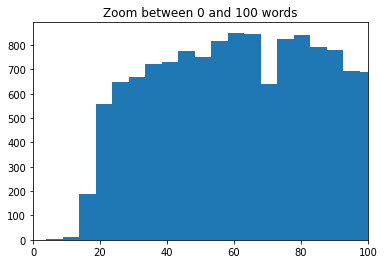

In [29]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(df_plot_fltr['nb_words'], bins=1000)
ax.set_title('Zoom between 0 and 100 words')
plt.xlim([0, 100])

plt.show()

We still find some extreme values in the distribution. In particular, some plots have less than 20 words, on the other hand there are plots with thousands of words.

In the preprocessing, we decided to discard the movies with plots that are less than 10 words as they might not be relevant when we will apply topic extraction.

### Distribution of the number of characters per movie

First we will group all the characters by movie. So if a movie has at least one labeled character, we will be able to count its number of character so that we can have an insight on the distribution of the number of characters for a movie.

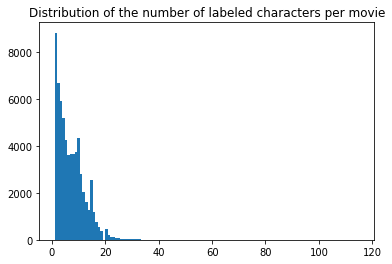

In [30]:
df_char_fltr = df_char[['freeID','FreeID_actor']].copy()
df_char_fltr = df_char_fltr.groupby(['freeID']).size()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(df_char_fltr, bins=120)
ax.set_title('Distribution of the number of labeled characters per movie')

plt.show()

In [31]:
print("Number of movies without any labeled character: ", 
      df_meta.shape[0] - df_meta[df_meta['freeID'].isin(df_char_fltr.index)].shape[0])

Number of movies without any labeled character:  17411


This can be missing information but it is also logical that some movies such as documentaries do not have any character.

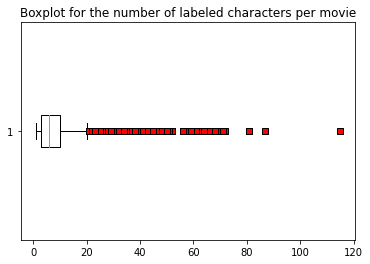

In [32]:
red_square = dict(markerfacecolor='r', marker='s')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(df_char_fltr, vert=False, flierprops=red_square)
ax.set_title('Boxplot for the number of labeled characters per movie')
plt.show()

In [33]:
print("1rst quartile, median and 3rd quartile values: ")
print(df_char_fltr.quantile([0.25,0.5,0.75]))

1rst quartile, median and 3rd quartile values: 
0.25     3.0
0.50     6.0
0.75    10.0
dtype: float64


## Join the dataframes

The feature connecting dataframes together is the Wikipedia ID. Also there are more metadatas of movies (81741 movies) than plots (42303 movies). We will only keep the metadatas of the movies we know the plot of.

In [34]:
df_full = df_meta.merge(df_plot, how='inner', on="wikiID")
df_full.head()

,wikiID,freeID,name,release_date,revenue,runtime,languages,countries,genres,plot
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
2,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002-01-01,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Every hundred years, the evil Morgana returns..."
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...","Adam, a San Francisco-based artist who works a..."


Only a small fraction of the characters have been labellised with a trope (500), compared to the number of unlabeled (450669). Here is the dataframe containing the characters with trope

In [35]:
df_char_trope = df_char.merge(df_tropes, how='inner', on='freeID_char_map')

df_char_trope.drop(columns=["char", "actor"], inplace=True)
df_char_trope.head()

,WikiID,freeID,release_date,char_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,Actor_age,freeID_char_map,FreeID_char,FreeID_actor,trope,movie
0,196176,/m/01bwgr,1971-11-03,David Sumner,1937-08-08,M,1.66,/m/041rx,Dustin Hoffman,34.0,/m/0k3v65,/m/0ch916z,/m/0bl2g,tranquil_fury,Straw Dogs
1,1157158,/m/04c13q,2002-03-29,Sheldon Mopes,1969-08-18,M,1.83,NaN,Edward Norton,32.0,/m/0jx3b8,/m/0gy99_8,/m/01515w,granola_person,Death to Smoochy
2,504242,/m/02j9_2,2005-08-22,Mr. Universe,1978-05-15,M,1.68,/m/041rx,David Krumholtz,27.0,/m/0k31lb,/m/02sgjdt,/m/05cx7x,playful_hacker,Serenity
3,6917005,/m/0gwypk,2003-02-16,Harold Hill,1962-03-21,M,1.73,/m/041rx,Matthew Broderick,40.0,/m/04hv61w,/m/09j606t,/m/01vlj1g,charmer,The Music Man
4,6917005,/m/0gwypk,2003-02-16,Harold Hill,1962-03-21,M,1.73,/m/041rx,Matthew Broderick,40.0,/m/04hv61w,/m/09j606t,/m/01vlj1g,loveable_rogue,The Music Man


---
## Preprocessing

We decided to filter our data, and remove the elements without a genre or with less than 10 words in their plot, because these are the features that we think are the most important in the idea of our project.

In [36]:
df_clean = (df_full[(df_full['genres'] != '{}') & (df_full['plot'].apply(lambda s: len(s.split())) > 10)]).drop(
    columns=['revenue'])

print('number of movies remaining after movie metadata preprocessing: ', df_clean.shape[0])

number of movies remaining after movie metadata preprocessing:  41783


We are formatting the data to facilitate the analysis.

In [37]:
df_clean['countries'] = pd.DataFrame(data={'countries': df_clean['countries'].apply(lambda x: list(json.loads(x).values()))})
df_clean['languages'] = pd.DataFrame(data={'languages': df_clean['languages'].apply(lambda x: list(json.loads(x).values()))})
df_clean['genres'] = pd.DataFrame(data={'genres': df_clean['genres'].apply(lambda x: list(json.loads(x).values()))}) 

We decided to replace the full release date by the year of release, so that all the movies have only an integer for this feature, and because we estimated that the year was sufficient to establish a similarity on the release date. 

In [38]:
df_clean['release_date'] = df_clean['release_date'].dt.year.apply(lambda x: int(x) if x == x else "")

We decided to redefine the runtime either as "short" for movies with a runtime less than 40 minutes (a short film is generally less than 40 minutes), "long" for movies with a runtime larger than 40 minutes or "unknown" if we do not know the runtime.

In [39]:
df_clean['runtime'] = df_clean['runtime'].apply(lambda x: 'short' if x <= 40 else ('long' if x > 40 else 'unknown'))

In [40]:
df_clean.head(20)

,wikiID,freeID,name,release_date,runtime,languages,countries,genres,plot
0,975900,/m/03vyhn,Ghosts of Mars,2001,long,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987,long,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
2,261236,/m/01mrr1,A Woman in Flames,1983,long,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra..."
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,long,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns..."
4,6631279,/m/0gffwj,Little city,1997,long,[English Language],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a..."
5,171005,/m/016ywb,Henry V,1989,long,[English Language],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
6,18296435,/m/04cqrs4,Aaah Belinda,1986,unknown,[Turkish Language],[Turkey],[Comedy],"Serap, a young actress with a strong, lively p..."
7,11250635,/m/02r52hc,The Mechanical Monsters,,unknown,[English Language],[United States of America],"[Science Fiction, Adventure, Animation, Short ...",The story starts as one of the robots flies i...
8,77856,/m/0kcn7,Mary Poppins,1964,long,[English Language],[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ...",The film opens with Mary Poppins perched in a...
10,21926710,/m/05p45cv,White on Rice,2009,long,[],[United States of America],"[Romantic comedy, Romance Film, Comedy, Indie]",Jimmy ([[Hiroshi Watanabe loves dinosaurs and...


---
## Scraping

We already performed test to scrape data with the code below.

In [41]:
import requests
from bs4 import BeautifulSoup
import pywikibot
from pywikibot import *

def scraping(wiki_ID):
    list = []

    query_base = "https://query.wikidata.org/bigdata/namespace/wdq/sparql?format=json&query="

    wiki_ID_encoded = wiki_ID.replace("/","%2F")

    pre_str = ( "https://query.wikidata.org/bigdata/namespace/wdq/sparql?format=json&query=PREFIX%20wd%3A%20%3Chttp%3A%2F%2" +
        "Fwww.wikidata.org%2Fentity%2F%3E%0APREFIX%20wdt%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fdirect%2F%3E%0APREF" +
        "IX%20wikibase%3A%20%3Chttp%3A%2F%2Fwikiba.se%2Fontology%23%3E%0A%0ASELECT%20%20%3Fs%20%3FsLabel%20%3Fp%20%20%3Fo%2" +
        "0%3FoLabel%20WHERE%20%7B%0A%20%3Fs%20wdt%3AP646%20%22" )
    post_str = ( "%22%20%0A%0A%20%20%20SERVICE%20wikibase%3Alabel%20%7B%0A%20%20%20%20bd%3AserviceParam%20wikibase%3Alangua" +
        "ge%20%22en%22%20.%0A%20%20%20%7D%0A%20%7D" )

    query = pre_str + wiki_ID_encoded + post_str

    response = requests.get(query)
    soup = BeautifulSoup(response.content, "html.parser")

    results = soup.find(id="results")

    try:
        entity_wiki_id = response.json()['results']['bindings'][0]['s']['value']
    except:
        print("Scraping failed")
        return [None,None]
        

    entity_wiki_id = response.json()['results']['bindings'][0]['s']['value']

    str = entity_wiki_id.split('/')
    entity = str[-1]
    print(entity)
    site = pywikibot.Site("wikidata", "wikidata")
    repo = site.data_repository()
    item = pywikibot.ItemPage(repo, entity)
    item_dict = item.get()
    clm_dict = item_dict["claims"] # Get the claim dictionary

    #P57 for a movie director
    try:
        clm_list = clm_dict["P57"]
        for clm in clm_list:
                ...
                clm_trgt = clm.getTarget()
        list.append(clm_trgt.labels['en'])
    except:
        list.append(None)

    #P462 for the color
    try:
        clm_list = clm_dict["P462"]
        for clm in clm_list:
                ...
                clm_trgt = clm.getTarget()
        list.append(clm_trgt.labels['en'])
    except:
        list.append(None)

    print('scraped sucessfuly')
    return list

In [42]:
sub_df = df_clean

list2 = [[]]
for index, row in sub_df.iterrows():
    list2.append(scraping(row['freeID']))

Q261700
scraped sucessfuly
Q7995657
scraped sucessfuly
Q869644
scraped sucessfuly
Scraping failed
Q6649585
scraped sucessfuly
Q114115
scraped sucessfuly
Q12808250
scraped sucessfuly
Q7750838
scraped sucessfuly
Q209170
scraped sucessfuly
Q7995659
scraped sucessfuly
Q4752515
scraped sucessfuly
Q607122
scraped sucessfuly
Q4914022
scraped sucessfuly
Q7914357
scraped sucessfuly
Q4769893
scraped sucessfuly
Q6368890
scraped sucessfuly
Q2943754
scraped sucessfuly
Q6378965
scraped sucessfuly
Q4786598
scraped sucessfuly
Q7845571
scraped sucessfuly
Q1156971
scraped sucessfuly
Q647665
scraped sucessfuly
Q2382723
scraped sucessfuly
Q535500
scraped sucessfuly
Q3521141
scraped sucessfuly
Q1030728
scraped sucessfuly
Q1061778
scraped sucessfuly
Q1710735
scraped sucessfuly
Q3206537
scraped sucessfuly
Scraping failed
Q2534503
scraped sucessfuly
Scraping failed
Q4686580
scraped sucessfuly
Q3423450
scraped sucessfuly
Q1987819
scraped sucessfuly
Q7093204
scraped sucessfuly
Scraping failed
Q6965941
scraped s

Q4779127
scraped sucessfuly
Scraping failed
Scraping failed
Q1729018
scraped sucessfuly
Q555014
scraped sucessfuly
Q1864826
scraped sucessfuly
Scraping failed
Q300559
scraped sucessfuly
Q3225254
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q16252434
scraped sucessfuly
Q1048645
scraped sucessfuly
Q558927
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q5085751
scraped sucessfuly
Q7312813
scraped sucessfuly
Q4667407
scraped sucessfuly
Scraping failed
Scraping failed
Q3214181
scraped sucessfuly
Q5271361
scraped sucessfuly
Q7993122
scraped sucessfuly
Q921599
scraped sucessfuly
Q6492739
scraped sucessfuly
Q7082032
scraped sucessfuly
Q12878223
scraped sucessfuly
Q771197
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q5271999
scraped sucessfuly
Q429520
scraped sucessfuly
Q5874617
scraped sucessfuly
Q7445924
scraped sucessfuly
Q129037
scra

Q12126037
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q4388331
scraped sucessfuly
Q504157
scraped sucessfuly
Q4471
scraped sucessfuly
Q7363062
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q2390868
scraped sucessfuly
Q1514240
scraped sucessfuly
Q1634805
scraped sucessfuly
Q5749159
scraped sucessfuly
Scraping failed
Q1757592
scraped sucessfuly
Q5399178
scraped sucessfuly
Q1775999
scraped sucessfuly
Q821753
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q5595879
scraped sucessfuly
Scraping failed
Q769286
scraped sucessfuly
Q4697372
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q3699170
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q6488750
scraped sucessfuly
Q7023699
scraped sucessfuly
Scraping failed
Scraping 

Q3796570
scraped sucessfuly
Q5172393
scraped sucessfuly
Scraping failed
Q1152489
scraped sucessfuly
Scraping failed
Scraping failed
Q6751078
scraped sucessfuly
Q1750312
scraped sucessfuly
Q813983
scraped sucessfuly
Q471569
scraped sucessfuly
Q7719752
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q282666
scraped sucessfuly
Q497256
scraped sucessfuly
Q787658
scraped sucessfuly
Q2401311
scraped sucessfuly
Scraping failed
Q7508277
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q3545595
scraped sucessfuly
Q498287
scraped sucessfuly
Q8000597
scraped sucessfuly
Q2035143
scraped sucessfuly
Q5312238
scraped sucessfuly
Scraping failed
Q19001
scraped sucessfuly
Q2699996
scraped sucessfuly
Q6928994
scraped sucessfuly
Q3227030
scraped sucessfuly
Q7295049
scraped sucessfuly
Q7721021
scraped sucessfuly
Q1254637
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q7676670
scraped sucessfuly
Q1464730
scraped sucessfuly
Q634105
scraped sucessfuly
Q

Scraping failed
Q1060430
scraped sucessfuly
Q580006
scraped sucessfuly
Q778709
scraped sucessfuly
Q3226877
scraped sucessfuly
Q2811296
scraped sucessfuly
Scraping failed
Q3207860
scraped sucessfuly
Q7711408
scraped sucessfuly
Q764764
scraped sucessfuly
Q18416077
scraped sucessfuly
Q72020
scraped sucessfuly
Scraping failed
Scraping failed
Q3633650
scraped sucessfuly
Q8073795
scraped sucessfuly
Q3324491
scraped sucessfuly
Scraping failed
Scraping failed
Q5245217
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q858508
scraped sucessfuly
Q2983721
scraped sucessfuly
Scraping failed
Scraping failed
Q5183620
scraped sucessfuly
Scraping failed
Scraping failed
Q2906938
scraped sucessfuly
Q1398997
scraped sucessfuly
Q3497560
scraped sucessfuly
Scraping failed
Q1117790
scraped sucessfuly
Q1961727
scraped sucessfuly
Scraping failed
Q4905600
scraped sucessfuly
Scraping failed
Scraping failed
Q6777943
scraped sucessfuly
Q1315888
scraped sucessfuly
Q107167
scraped sucessfuly
Q12125

scraped sucessfuly
Scraping failed
Q3424373
scraped sucessfuly
Scraping failed
Q4656702
scraped sucessfuly
Q3282302
scraped sucessfuly
Q2289046
scraped sucessfuly
Q1132905
scraped sucessfuly
Q719959
scraped sucessfuly
Q6781058
scraped sucessfuly
Q1545826
scraped sucessfuly
Q7713428
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q607480
scraped sucessfuly
Q5264534
scraped sucessfuly
Scraping failed
Q976934
scraped sucessfuly
Q917403
scraped sucessfuly
Q4878630
scraped sucessfuly
Scraping failed
Q5546702
scraped sucessfuly
Scraping failed
Q6675534
scraped sucessfuly
Scraping failed
Q776808
scraped sucessfuly
Q1568485
scraped sucessfuly
Scraping failed
Q4820549
scraped sucessfuly
Scraping failed
Scraping failed
Q751279
scraped sucessfuly
Q6115019
scraped sucessfuly
Scraping failed
Q1139031
scraped sucessfuly
Q1215427
scraped sucessfuly
Q3204494
scraped sucessfuly
Q892346
scraped sucessfuly
Q1351935
scraped sucessfuly
Q4927835
scraped suc

scraped sucessfuly
Q1426984
scraped sucessfuly
Q1660028
scraped sucessfuly
Q7278879
scraped sucessfuly
Scraping failed
Q7993475
scraped sucessfuly
Q5001845
scraped sucessfuly
Scraping failed
Q3204218
scraped sucessfuly
Q152456
scraped sucessfuly
Q5937065
scraped sucessfuly
Q992227
scraped sucessfuly
Q1140745
scraped sucessfuly
Q7978225
scraped sucessfuly
Q7781357
scraped sucessfuly
Scraping failed
Q890060
scraped sucessfuly
Q7741659
scraped sucessfuly
Q223043
scraped sucessfuly
Q14948481
scraped sucessfuly
Q2248695
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q276343
scraped sucessfuly
Q276769
scraped sucessfuly
Q1170012
scraped sucessfuly
Q1961913
scraped sucessfuly
Scraping failed
Q955540
scraped sucessfuly
Q193695
scraped sucessfuly
Q1340566
scraped sucessfuly
Q12125107
scraped sucessfuly
Scraping failed
Q1100445
scraped sucessfuly
Q5026942
scraped sucessfuly
Q7036866
scraped sucessfuly
Scraping failed
Q1924126
scraped sucessfuly
Q1137042
scrape

Q2327769
scraped sucessfuly
Q3024253
scraped sucessfuly
Q5037100
scraped sucessfuly
Q1168623
scraped sucessfuly
Q7445554
scraped sucessfuly
Scraping failed
Scraping failed
Q6890738
scraped sucessfuly
Q779121
scraped sucessfuly
Q4633311
scraped sucessfuly
Q842253
scraped sucessfuly
Q780197
scraped sucessfuly
Q5182312
scraped sucessfuly
Q1089283
scraped sucessfuly
Q6802928
scraped sucessfuly
Q7045930
scraped sucessfuly
Q3525927
scraped sucessfuly
Q2053630
scraped sucessfuly
Q7402789
scraped sucessfuly
Q3115376
scraped sucessfuly
Scraping failed
Q2510531
scraped sucessfuly
Scraping failed
Q5460949
scraped sucessfuly
Q2633757
scraped sucessfuly
Q2811356
scraped sucessfuly
Q494085
scraped sucessfuly
Q464964
scraped sucessfuly
Q76827
scraped sucessfuly
Q3790311
scraped sucessfuly
Q273676
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q167432
scraped sucessfuly
Q1400498
scraped sucessfuly
Q975358
scraped sucessfuly
Q7426177
scraped sucessful

Q168862
scraped sucessfuly
Q586199
scraped sucessfuly
Q561982
scraped sucessfuly
Q7462585
scraped sucessfuly
Q6656112
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q3128070
scraped sucessfuly
Scraping failed
Q3595073
scraped sucessfuly
Q4761817
scraped sucessfuly
Scraping failed
Scraping failed
Q1518288
scraped sucessfuly
Q4920759
scraped sucessfuly
Scraping failed
Q493089
scraped sucessfuly
Q746730
scraped sucessfuly
Q759335
scraped sucessfuly
Q1761295
scraped sucessfuly
Q1137254
scraped sucessfuly
Q7539022
scraped sucessfuly
Scraping failed
Scraping failed
Q4626745
scraped sucessfuly
Q7145126
scraped sucessfuly
Scraping failed
Q29658
scraped sucessfuly
Q2439201
scraped sucessfuly
Q16174790
scraped sucessfuly
Q1021977
scraped sucessfuly
Q7855854
scraped sucessfuly
Q5251030
scraped sucessfuly
Q837536
scraped sucessfuly
Q342876
scraped sucessfuly
Q772260
scraped sucessfuly
Q7746251
scraped sucessfuly
Scraping failed
Q5

Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q4779122
scraped sucessfuly
Scraping failed
Scraping failed
Q729794
scraped sucessfuly
Q1085302
scraped sucessfuly
Q1165259
scraped sucessfuly
Q570180
scraped sucessfuly
Q4928949
scraped sucessfuly
Q1961904
scraped sucessfuly
Q7721352
scraped sucessfuly
Scraping failed
Scraping failed
Q7627463
scraped sucessfuly
Scraping failed
Q5520783
scraped sucessfuly
Q1498454
scraped sucessfuly
Q1125262
scraped sucessfuly
Q1671510
scraped sucessfuly
Q7280702
scraped sucessfuly
Scraping failed
Q6726233
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q7898099
scraped sucessfuly
Scraping failed
Q639855
scraped sucessfuly
Q7573568
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q4660786
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q899236
scraped sucessfuly
Q4041833
scraped sucessfuly
Q1569216
scraped

ERROR: Traceback (most recent call last):
  File "/home/taras/.local/lib/python3.8/site-packages/pywikibot/data/api/_requests.py", line 679, in _http_request
    response = http.request(self.site, uri=uri,
  File "/home/taras/.local/lib/python3.8/site-packages/pywikibot/comms/http.py", line 232, in request
    r = fetch(baseuri, headers=headers, **kwargs)
  File "/home/taras/.local/lib/python3.8/site-packages/pywikibot/comms/http.py", line 393, in fetch
    callback(response)
  File "/home/taras/.local/lib/python3.8/site-packages/pywikibot/comms/http.py", line 283, in error_handling_callback
    raise response from None
  File "/home/taras/.local/lib/python3.8/site-packages/pywikibot/comms/http.py", line 384, in fetch
    response = session.request(method, uri,
  File "/usr/lib/python3/dist-packages/requests/sessions.py", line 533, in request
    resp = self.send(prep, **send_kwargs)
  File "/usr/lib/python3/dist-packages/requests/sessions.py", line 686, in send
    r.content
  File "/

scraped sucessfuly
Scraping failed
Q776098
scraped sucessfuly
Q4020988
scraped sucessfuly
Q1527383
scraped sucessfuly
Q3403703
scraped sucessfuly
Q2563734
scraped sucessfuly
Q971468
scraped sucessfuly
Q4204477
scraped sucessfuly
Q3606435
scraped sucessfuly
Q848664
scraped sucessfuly
Q542688
scraped sucessfuly
Q7980343
scraped sucessfuly
Q6928831
scraped sucessfuly
Q3226941
scraped sucessfuly
Q5172623
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q1193825
scraped sucessfuly
Q1325217
scraped sucessfuly
Q7859110
scraped sucessfuly
Q214013
scraped sucessfuly
Q1211871
scraped sucessfuly
Q13060184
scraped sucessfuly
Q7735982
scraped sucessfuly
Q246126
scraped sucessfuly
Scraping failed
Q4659803
scraped sucessfuly
Scraping failed
Q1129317
scraped sucessfuly
Q5448281
scraped sucessfuly
Scraping failed
Q5215583
scraped sucessfuly
Q322664
scraped sucessfuly
Q1364051
scraped sucessfuly
Q4531833
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed

Q431252
scraped sucessfuly
Q5103535
scraped sucessfuly
Scraping failed
Q2307542
scraped sucessfuly
Q371592
scraped sucessfuly
Q1608853
scraped sucessfuly
Q1256231
scraped sucessfuly
Q3213459
scraped sucessfuly
Q3033503
scraped sucessfuly
Q2032557
scraped sucessfuly
Q969428
scraped sucessfuly
Q7907829
scraped sucessfuly
Scraping failed
Q5434031
scraped sucessfuly
Scraping failed
Scraping failed
Q3210212
scraped sucessfuly
Scraping failed
Q7784361
scraped sucessfuly
Q6361172
scraped sucessfuly
Scraping failed
Scraping failed
Q7804412
scraped sucessfuly
Q6422107
scraped sucessfuly
Q7374369
scraped sucessfuly
Scraping failed
Q227460
scraped sucessfuly
Scraping failed
Q5693040
scraped sucessfuly
Q3478808
scraped sucessfuly
Q161687
scraped sucessfuly
Q4751720
scraped sucessfuly
Scraping failed
Q1167736
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q625424
scraped sucessfuly
Q1147356
scraped sucessfuly
Q6037562
scraped sucessfuly
Q6091042
s

Q1996268
scraped sucessfuly
Q3324719
scraped sucessfuly
Q5580864
scraped sucessfuly
Scraping failed
Q926309
scraped sucessfuly
Q5017013
scraped sucessfuly
Scraping failed
Scraping failed
Q2410110
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q4634487
scraped sucessfuly
Scraping failed
Q12125875
scraped sucessfuly
Q2788727
scraped sucessfuly
Q1029697
scraped sucessfuly
Q6943399
scraped sucessfuly
Scraping failed
Scraping failed
Q246391
scraped sucessfuly
Q3535757
scraped sucessfuly
Q5658294
scraped sucessfuly
Scraping failed
Q6733254
scraped sucessfuly
Scraping failed
Scraping failed
Q142637
scraped sucessfuly
Q4691059
scraped sucessfuly
Q15983115
scraped sucessfuly
Q12154691
scraped sucessfuly
Scraping failed
Q400985
scraped sucessfuly
Q3368385
scraped sucessfuly
Scraping failed
Q960349
scraped sucessfuly
Q12125213
scraped sucessfuly
Q2929328
scraped sucessfuly
Scraping failed
Q964634
scraped sucessfuly
Scraping failed
Scraping faile

scraped sucessfuly
Q3005765
scraped sucessfuly
Q7619570
scraped sucessfuly
Scraping failed
Q1144382
scraped sucessfuly
Q2381729
scraped sucessfuly
Q1813331
scraped sucessfuly
Q5691833
scraped sucessfuly
Q1798917
scraped sucessfuly
Q2642487
scraped sucessfuly
Q4985027
scraped sucessfuly
Scraping failed
Q7825306
scraped sucessfuly
Q1218856
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q1431684
scraped sucessfuly
Q27536
scraped sucessfuly
Q5352534
scraped sucessfuly
Scraping failed
Q7994708
scraped sucessfuly
Q3073055
scraped sucessfuly
Scraping failed
Q1754564
scraped sucessfuly
Q3059118
scraped sucessfuly
Scraping failed
Q1616030
scraped sucessfuly
Q6784889
scraped sucessfuly
Scraping failed
Q7738326
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q3821668
scraped sucessfuly
Scraping failed
Q1651091
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q6312385
scraped su

Q7712588
scraped sucessfuly
Q5313398
scraped sucessfuly
Scraping failed
Q1547621
scraped sucessfuly
Q2113655
scraped sucessfuly
Q15982471
scraped sucessfuly
Q685163
scraped sucessfuly
Q51732
scraped sucessfuly
Q1662410
scraped sucessfuly
Q6315734
scraped sucessfuly
Q1534001
scraped sucessfuly
Q3137760
scraped sucessfuly
Q1410288
scraped sucessfuly
Q549908
scraped sucessfuly
Q3427485
scraped sucessfuly
Scraping failed
Q549859
scraped sucessfuly
Q4193220
scraped sucessfuly
Q6471742
scraped sucessfuly
Q3986580
scraped sucessfuly
Q7919599
scraped sucessfuly
Q192403
scraped sucessfuly
Q7716027
scraped sucessfuly
Q5122546
scraped sucessfuly
Q5918716
scraped sucessfuly
Q451558
scraped sucessfuly
Q3625848
scraped sucessfuly
Q3125535
scraped sucessfuly
Scraping failed
Q6202864
scraped sucessfuly
Q3278926
scraped sucessfuly
Q7430794
scraped sucessfuly
Q4266474
scraped sucessfuly
Q733000
scraped sucessfuly
Q7796926
scraped sucessfuly
Q3472831
scraped sucessfuly
Scraping failed
Scraping failed
Q22

Scraping failed
Scraping failed
Q3843985
scraped sucessfuly
Q3563548
scraped sucessfuly
Q3616469
scraped sucessfuly
Q15040686
scraped sucessfuly
Q7757929
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q5051383
scraped sucessfuly
Q1199877
scraped sucessfuly
Q785373
scraped sucessfuly
Q5335771
scraped sucessfuly
Scraping failed
Scraping failed
Q1211239
scraped sucessfuly
Q7979048
scraped sucessfuly
Q371278
scraped sucessfuly
Q6925242
scraped sucessfuly
Scraping failed
Q4751326
scraped sucessfuly
Scraping failed
Q7250895
scraped sucessfuly
Scraping failed
Q7805067
scraped sucessfuly
Q316225
scraped sucessfuly
Q7049390
scraped sucessfuly
Scraping failed
Scraping failed
Q12125759
scraped sucessfuly
Q3790020
scraped sucessfuly
Q4552081
scraped sucessfuly
Scraping failed
Q5715211
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q7141515
scraped sucessfuly
Q3997547
scraped sucessfuly
Q1058019
scraped sucessfu

Q182300
scraped sucessfuly
Q4127103
scraped sucessfuly
Q5167339
scraped sucessfuly
Scraping failed
Q1627914
scraped sucessfuly
Q853646
scraped sucessfuly
Q5116522
scraped sucessfuly
Scraping failed
Q1319963
scraped sucessfuly
Q4714847
scraped sucessfuly
Q7773591
scraped sucessfuly
Q644316
scraped sucessfuly
Q3125816
scraped sucessfuly
Q762077
scraped sucessfuly
Q1215008
scraped sucessfuly
Q646234
scraped sucessfuly
Q2409475
scraped sucessfuly
Q3221717
scraped sucessfuly
Scraping failed
Scraping failed
Q6529234
scraped sucessfuly
Scraping failed
Q279057
scraped sucessfuly
Q3794929
scraped sucessfuly
Scraping failed
Q1090788
scraped sucessfuly
Q5273476
scraped sucessfuly
Q193066
scraped sucessfuly
Q269887
scraped sucessfuly
Q7197756
scraped sucessfuly
Scraping failed
Q7195893
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q3105932
scraped sucessfuly
Scraping failed
Q3922169
scraped sucessfuly
Q7762076
scraped sucessfuly
Q135399
scraped sucessfuly
Q6057970
scraped suce

Q7547580
scraped sucessfuly
Q8030795
scraped sucessfuly
Q3212086
scraped sucessfuly
Q6822832
scraped sucessfuly
Q383355
scraped sucessfuly
Q4900903
scraped sucessfuly
Scraping failed
Q3295248
scraped sucessfuly
Scraping failed
Q1680069
scraped sucessfuly
Q3124318
scraped sucessfuly
Q7500200
scraped sucessfuly
Scraping failed
Scraping failed
Q462447
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q6880481
scraped sucessfuly
Q3793642
scraped sucessfuly
Q7738484
scraped sucessfuly
Q500403
scraped sucessfuly
Q7123870
scraped sucessfuly
Scraping failed
Scraping failed
Q1941014
scraped sucessfuly
Q1620394
scraped sucessfuly
Q464042
scraped sucessfuly
Q2850168
scraped sucessfuly
Q4911654
scraped sucessfuly
Scraping failed
Q4661622
scraped sucessfuly
Scraping failed
Q5250307
scraped sucessfuly
Scraping failed
Q699028
scraped sucessfuly
Q1934832
scraped sucessfuly
Q1921451
scraped sucessfuly
Q7747482
scraped sucessfuly
Q4656516
scraped sucessfu

scraped sucessfuly
Q7757868
scraped sucessfuly
Q1159199
scraped sucessfuly
Q544766
scraped sucessfuly
Q920681
scraped sucessfuly
Scraping failed
Q2153352
scraped sucessfuly
Q4359782
scraped sucessfuly
Q1141731
scraped sucessfuly
Q1216648
scraped sucessfuly
Q3029740
scraped sucessfuly
Q840495
scraped sucessfuly
Q6413042
scraped sucessfuly
Q2915397
scraped sucessfuly
Q689245
scraped sucessfuly
Q4702128
scraped sucessfuly
Q1630741
scraped sucessfuly
Q5435687
scraped sucessfuly
Scraping failed
Q1050815
scraped sucessfuly
Q1471937
scraped sucessfuly
Q2083048
scraped sucessfuly
Q4545957
scraped sucessfuly
Q2562723
scraped sucessfuly
Q260548
scraped sucessfuly
Q1508797
scraped sucessfuly
Q7144979
scraped sucessfuly
Q1635199
scraped sucessfuly
Q4661518
scraped sucessfuly
Q5496829
scraped sucessfuly
Scraping failed
Q277605
scraped sucessfuly
Q699321
scraped sucessfuly
Scraping failed
Scraping failed
Q1961833
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scra

Q2384898
scraped sucessfuly
Q547863
scraped sucessfuly
Q7911816
scraped sucessfuly
Q1218039
scraped sucessfuly
Q3641257
scraped sucessfuly
Q501105
scraped sucessfuly
Q6772851
scraped sucessfuly
Q252529
scraped sucessfuly
Q2564571
scraped sucessfuly
Q5433501
scraped sucessfuly
Q383173
scraped sucessfuly
Q6154041
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q6945434
scraped sucessfuly
Q3376112
scraped sucessfuly
Q7137017
scraped sucessfuly
Scraping failed
Scraping failed
Q2840651
scraped sucessfuly
Scraping failed
Q2009982
scraped sucessfuly
Q761548
scraped sucessfuly
Q7039952
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q5422819
scraped sucessfuly
Scraping failed
Q1217069
scraped sucessfuly
Q8250724
scraped sucessfuly
Q7459924
scraped sucessfuly
Q7754530
scraped sucessfuly
Q372299
scraped sucessfuly
Q1407454
scraped sucessfuly
Q7937978
scraped sucessfuly
Q4052979
scraped sucessfuly
Scraping failed
Scraping faile

Q6470636
scraped sucessfuly
Q700037
scraped sucessfuly
Q5394052
scraped sucessfuly
Scraping failed
Q7125003
scraped sucessfuly
Scraping failed
Q3111804
scraped sucessfuly
Scraping failed
Q10381445
scraped sucessfuly
Q4827199
scraped sucessfuly
Scraping failed
Scraping failed
Q7621635
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q1206788
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q276415
scraped sucessfuly
Q3793118
scraped sucessfuly
Q7571042
scraped sucessfuly
Q6360121
scraped sucessfuly
Q6945031
scraped sucessfuly
Q380841
scraped sucessfuly
Q188019
scraped sucessfuly
Q25760
scraped sucessfuly
Q3233839
scraped sucessfuly
Q5225923
scraped sucessfuly
Scraping failed
Scraping failed
Q1584406
scraped sucessfuly
Q3819406
scraped sucessfuly
Q4817947
scraped sucessfuly
Scraping failed
Q6219250
scraped sucessfuly
Scraping failed
Scraping failed
Q3283124
scraped sucessfu

Q639387
scraped sucessfuly
Q4919074
scraped sucessfuly
Q1762507
scraped sucessfuly
Scraping failed
Q3523221
scraped sucessfuly
Q3202558
scraped sucessfuly
Scraping failed
Scraping failed
Q4421648
scraped sucessfuly
Scraping failed
Q7111953
scraped sucessfuly
Scraping failed
Q671397
scraped sucessfuly
Q2436011
scraped sucessfuly
Q5457240
scraped sucessfuly
Scraping failed
Q5299676
scraped sucessfuly
Q3212098
scraped sucessfuly
Scraping failed
Q2897243
scraped sucessfuly
Q3002430
scraped sucessfuly
Q1624872
scraped sucessfuly
Q6238546
scraped sucessfuly
Scraping failed
Q458802
scraped sucessfuly
Q1754704
scraped sucessfuly
Q178211
scraped sucessfuly
Q6725978
scraped sucessfuly
Q6528065
scraped sucessfuly
Scraping failed
Q3280654
scraped sucessfuly
Q5431005
scraped sucessfuly
Scraping failed
Q230616
scraped sucessfuly
Q1626585
scraped sucessfuly
Q3644934
scraped sucessfuly
Scraping failed
Scraping failed
Q2754849
scraped sucessfuly
Q1675435
scraped sucessfuly
Q1124501
scraped sucessfuly
S

Q7998262
scraped sucessfuly
Q568465
scraped sucessfuly
Q940400
scraped sucessfuly
Q3155480
scraped sucessfuly
Scraping failed
Scraping failed
Q502033
scraped sucessfuly
Q820521
scraped sucessfuly
Q7379521
scraped sucessfuly
Q7732641
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q2568665
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q219179
scraped sucessfuly
Scraping failed
Q2655141
scraped sucessfuly
Scraping failed
Q2654601
scraped sucessfuly
Q3821447
scraped sucessfuly
Q3365581
scraped sucessfuly
Q4359887
scraped sucessfuly
Scraping failed
Scraping failed
Q2263943
scraped sucessfuly
Q873186
scraped sucessfuly
Q1192655
scraped sucessfuly
Q5161258
scraped sucessfuly
Q219776
scraped sucessfuly
Q3461624
scraped sucessfuly
Scraping failed
Scraping failed
Q6648920
scraped sucessfuly
Q757976
scraped sucessfuly
Q5189964
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed


Q679670
scraped sucessfuly
Q5299709
scraped sucessfuly
Q784066
scraped sucessfuly
Q1763031
scraped sucessfuly
Q484099
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q1139262
scraped sucessfuly
Q5140028
scraped sucessfuly
Scraping failed
Q94686
scraped sucessfuly
Q5582384
scraped sucessfuly
Q4657472
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q2599048
scraped sucessfuly
Q1503878
scraped sucessfuly
Q4229600
scraped sucessfuly
Q277296
scraped sucessfuly
Q532461
scraped sucessfuly
Q2704813
scraped sucessfuly
Q8068294
scraped sucessfuly
Q6986572
scraped sucessfuly
Q3231790
scraped sucessfuly
Q214801
scraped sucessfuly
Q661422
scraped sucessfuly
Q3217947
scraped sucessfuly
Scraping failed
Scraping failed
Q1415845
scraped sucessfuly
Q7557263
scraped sucessfuly
Q6548587
scraped sucessfuly
Q471720
scraped sucessfuly
Q1361113
scraped sucessfuly
Q1140961
scraped sucessfuly
Q2711786
scraped s

Scraping failed
Q2902355
scraped sucessfuly
Q2995981
scraped sucessfuly
Scraping failed
Q7044986
scraped sucessfuly
Scraping failed
Q12128785
scraped sucessfuly
Q3538365
scraped sucessfuly
Q7729665
scraped sucessfuly
Q5266421
scraped sucessfuly
Scraping failed
Q733570
scraped sucessfuly
Q191418
scraped sucessfuly
Q4765663
scraped sucessfuly
Q920474
scraped sucessfuly
Q986119
scraped sucessfuly
Q1052260
scraped sucessfuly
Q7699464
scraped sucessfuly
Q228667
scraped sucessfuly
Q7228898
scraped sucessfuly
Q4656819
scraped sucessfuly
Scraping failed
Scraping failed
Q8000559
scraped sucessfuly
Q1130644
scraped sucessfuly
Q921936
scraped sucessfuly
Q688860
scraped sucessfuly
Q3033507
scraped sucessfuly
Q779032
scraped sucessfuly
Q5620350
scraped sucessfuly
Scraping failed
Q7785923
scraped sucessfuly
Scraping failed
Q7070165
scraped sucessfuly
Q5237059
scraped sucessfuly
Q3429787
scraped sucessfuly
Q4721860
scraped sucessfuly
Q8073736
scraped sucessfuly
Scraping failed
Q5180473
scraped sucess

Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q5614606
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q22315103
scraped sucessfuly
Q4911248
scraped sucessfuly
Scraping failed
Scraping failed
Q3801196
scraped sucessfuly
Q1643166
scraped sucessfuly
Q2405812
scraped sucessfuly
Q3207525
scraped sucessfuly
Q6436115
scraped sucessfuly
Q1218665
scraped sucessfuly
Q5874818
scraped sucessfuly
Scraping failed
Scraping failed
Q780350
scraped sucessfuly
Q5996747
scraped sucessfuly
Q1157757
scraped sucessfuly
Q618274
scraped sucessfuly
Q2606467
scraped sucessfuly
Q6517812
scraped sucessfuly
Q289043
scraped sucessfuly
Q456467
scraped sucessfuly
Q2298780
scraped sucessfuly
Q1474127
scraped sucessfuly
Q1814939
scraped sucessfuly
Q3306737
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q3614579
scraped sucessfuly
Q159063
scraped sucessfuly
Q5451292
scraped sucessfuly


Q8564228
scraped sucessfuly
Q3523105
scraped sucessfuly
Scraping failed
Q742541
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q157556
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q7228910
scraped sucessfuly
Q5936343
scraped sucessfuly
Q5882786
scraped sucessfuly
Q1193261
scraped sucessfuly
Q3536743
scraped sucessfuly
Scraping failed
Q4655501
scraped sucessfuly
Q2421355
scraped sucessfuly
Q432986
scraped sucessfuly
Q834530
scraped sucessfuly
Q661560
scraped sucessfuly
Q1105584
scraped sucessfuly
Q7562751
scraped sucessfuly
Scraping failed
Q7738360
scraped sucessfuly
Q7128558
scraped sucessfuly
Scraping failed
Q2072594
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q4659633
scraped sucessfuly
Q7503447
scraped sucessfuly
Q458033
scraped sucessfuly
Q1209866
scraped sucessfuly
Q1345807
scraped sucessfuly
Q2362805
scraped sucessfuly
Q3837985
scraped s

scraped sucessfuly
Q3283683
scraped sucessfuly
Q5118151
scraped sucessfuly
Scraping failed
Q155559
scraped sucessfuly
Q13114578
scraped sucessfuly
Q7753884
scraped sucessfuly
Scraping failed
Scraping failed
Q1498223
scraped sucessfuly
Q421750
scraped sucessfuly
Q7142489
scraped sucessfuly
Q7943956
scraped sucessfuly
Q1610996
scraped sucessfuly
Q2779056
scraped sucessfuly
Q3419886
scraped sucessfuly
Scraping failed
Scraping failed
Q7148319
scraped sucessfuly
Scraping failed
Q727160
scraped sucessfuly
Q7285399
scraped sucessfuly
Q6783264
scraped sucessfuly
Scraping failed
Q7242199
scraped sucessfuly
Q2036518
scraped sucessfuly
Q1400892
scraped sucessfuly
Q926839
scraped sucessfuly
Q322206
scraped sucessfuly
Q3545949
scraped sucessfuly
Scraping failed
Q379983
scraped sucessfuly
Q2353527
scraped sucessfuly
Q7753557
scraped sucessfuly
Q4015024
scraped sucessfuly
Q14957241
scraped sucessfuly
Q744658
scraped sucessfuly
Q1348490
scraped sucessfuly
Q5276858
scraped sucessfuly
Scraping failed
Q3

Q1750530
scraped sucessfuly
Scraping failed
Q2294175
scraped sucessfuly
Q1059886
scraped sucessfuly
Q766637
scraped sucessfuly
Q984139
scraped sucessfuly
Q7588379
scraped sucessfuly
Scraping failed
Q549012
scraped sucessfuly
Q127760
scraped sucessfuly
Q1093673
scraped sucessfuly
Q2263399
scraped sucessfuly
Q6738919
scraped sucessfuly
Q1962870
scraped sucessfuly
Q2909304
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q1215977
scraped sucessfuly
Q12129179
scraped sucessfuly
Q6738760
scraped sucessfuly
Q16250950
scraped sucessfuly
Q4526407
scraped sucessfuly
Scraping failed
Scraping failed
Q7563717
scraped sucessfuly
Q2599933
scraped sucessfuly
Q3415074
scraped sucessfuly
Q7083513
scraped sucessfuly
Q244511
scraped sucessfuly
Q5594743
scraped sucessfuly
Scraping failed
Q12448284
scraped sucessfuly
Q669619
scraped sucessfuly
Q3842255
scraped sucessfuly
Q7620091
scraped sucessfuly
Scraping failed
Q4213036
scraped sucessfuly
Q16255346
scraped sucessfuly
Q1519075
scraped s

scraped sucessfuly
Q3988992
scraped sucessfuly
Q18325698
scraped sucessfuly
Q730436
scraped sucessfuly
Q3277693
scraped sucessfuly
Q1540202
scraped sucessfuly
Q7821735
scraped sucessfuly
Q6276224
scraped sucessfuly
Q3651324
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q6122038
scraped sucessfuly
Q3280697
scraped sucessfuly
Q2162222
scraped sucessfuly
Scraping failed
Scraping failed
Q7857771
scraped sucessfuly
Q4661141
scraped sucessfuly
Scraping failed
Q1304590
scraped sucessfuly
Q118829
scraped sucessfuly
Q650613
scraped sucessfuly
Q458656
scraped sucessfuly
Q3532529
scraped sucessfuly
Q1783771
scraped sucessfuly
Q2352876
scraped sucessfuly
Q1169497
scraped sucessfuly
Q5584325
scraped sucessfuly
Scraping failed
Q1404374
scraped sucessfuly
Q1254861
scraped sucessfuly
Q3033842
scraped sucessfuly
Scraping failed
Q3062444
scraped sucessfuly
Q7366535
scraped sucessfuly
Q4658376
scraped sucessfuly
Scraping failed
Q5303316
scraped sucessf

Q7712323
scraped sucessfuly
Q2992240
scraped sucessfuly
Q4751445
scraped sucessfuly
Scraping failed
Scraping failed
Q3964670
scraped sucessfuly
Q1171765
scraped sucessfuly
Q6034266
scraped sucessfuly
Scraping failed
Q914133
scraped sucessfuly
Q3520830
scraped sucessfuly
Q7457166
scraped sucessfuly
Q258647
scraped sucessfuly
Q2041865
scraped sucessfuly
Q3042732
scraped sucessfuly
Scraping failed
Scraping failed
Q122713
scraped sucessfuly
Q2457553
scraped sucessfuly
Q1962395
scraped sucessfuly
Scraping failed
Q232036
scraped sucessfuly
Scraping failed
Q3411010
scraped sucessfuly
Q6750643
scraped sucessfuly
Scraping failed
Q717206
scraped sucessfuly
Scraping failed
Q3331165
scraped sucessfuly
Scraping failed
Scraping failed
Q1519981
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q1753894
scraped sucessfuly
Q7396452
scraped sucessfuly
Scraping failed
Q696905
scraped sucessfuly
Q2084054
scraped sucessfuly
Q4174688
scraped sucessfuly
Scraping failed
Q32137

Q685516
scraped sucessfuly
Q591556
scraped sucessfuly
Q7459913
scraped sucessfuly
Q1161843
scraped sucessfuly
Q5270884
scraped sucessfuly
Scraping failed
Q3200631
scraped sucessfuly
Scraping failed
Scraping failed
Q1251094
scraped sucessfuly
Q3473448
scraped sucessfuly
Q7216
scraped sucessfuly
Q7237322
scraped sucessfuly
Q16376665
scraped sucessfuly
Q222040
scraped sucessfuly
Q6441390
scraped sucessfuly
Q4842934
scraped sucessfuly
Scraping failed
Q16954725
scraped sucessfuly
Scraping failed
Q4899130
scraped sucessfuly
Scraping failed
Scraping failed
Q3070966
scraped sucessfuly
Q2040235
scraped sucessfuly
Scraping failed
Q5466904
scraped sucessfuly
Q7077076
scraped sucessfuly
Scraping failed
Q6991671
scraped sucessfuly
Q1800357
scraped sucessfuly
Q471423
scraped sucessfuly
Q553194
scraped sucessfuly
Q12126302
scraped sucessfuly
Scraping failed
Q7757022
scraped sucessfuly
Scraping failed
Q426196
scraped sucessfuly
Q1516532
scraped sucessfuly
Q1272202
scraped sucessfuly
Q6059058
scraped s

Scraping failed
Q6945697
scraped sucessfuly
Q2906966
scraped sucessfuly
Scraping failed
Scraping failed
Q1474655
scraped sucessfuly
Q5625261
scraped sucessfuly
Q1199728
scraped sucessfuly
Q7825300
scraped sucessfuly
Q4156191
scraped sucessfuly
Q323306
scraped sucessfuly
Q7728330
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q2112932
scraped sucessfuly
Q1542071
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q6373744
scraped sucessfuly
Scraping failed
Scraping failed
Q9006627
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q3424333
scraped sucessfuly
Scraping failed
Scraping failed
Q7847371
scraped sucessfuly
Q367244
scraped sucessfuly
Q3568217
scraped sucessfuly
Scraping failed
Q432526
scraped sucessfuly
Q264943
scraped sucessfuly
Q5975986
scraped sucessf

Q3644997
scraped sucessfuly
Scraping failed
Scraping failed
Q12126211
scraped sucessfuly
Q1057852
scraped sucessfuly
Q1992724
scraped sucessfuly
Q4876860
scraped sucessfuly
Scraping failed
Q7023630
scraped sucessfuly
Q4222998
scraped sucessfuly
Scraping failed
Q2545539
scraped sucessfuly
Q4306681
scraped sucessfuly
Q2757468
scraped sucessfuly
Q2904612
scraped sucessfuly
Q2060077
scraped sucessfuly
Q581733
scraped sucessfuly
Q7432286
scraped sucessfuly
Q7768153
scraped sucessfuly
Q6683916
scraped sucessfuly
Scraping failed
Scraping failed
Q821815
scraped sucessfuly
Q1427252
scraped sucessfuly
Q7333562
scraped sucessfuly
Q5208336
scraped sucessfuly
Q5156256
scraped sucessfuly
Scraping failed
Scraping failed
Q5979497
scraped sucessfuly
Q7745888
scraped sucessfuly
Q1613737
scraped sucessfuly
Q3100549
scraped sucessfuly
Scraping failed
Q3666921
scraped sucessfuly
Q174785
scraped sucessfuly
Q3818457
scraped sucessfuly
Q1596968
scraped sucessfuly
Q7804870
scraped sucessfuly
Q7163044
scraped s

Q263714
scraped sucessfuly
Q7033542
scraped sucessfuly
Q13642776
scraped sucessfuly
Q875234
scraped sucessfuly
Q4771448
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q1140565
scraped sucessfuly
Q838561
scraped sucessfuly
Q3401176
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q7799527
scraped sucessfuly
Scraping failed
Q730473
scraped sucessfuly
Q7797842
scraped sucessfuly
Q902553
scraped sucessfuly
Q2928795
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q624974
scraped sucessfuly
Q1139072
scraped sucessfuly
Q287179
scraped sucessfuly
Q3301960
scraped sucessfuly
Q752552
scraped sucessfuly
Q1858817
scraped sucessfuly
Q6123038
scraped sucessfuly
Scraping failed
Scraping failed
Q270470
scraped sucessfuly
Q4019762
scraped sucessfuly
Scraping failed
Q189540
scraped sucessfuly
Q369346
scraped sucessfuly
Q3355798
scraped sucessfuly
Q3648154
scraped sucessfuly
Q221594
scraped sucessfuly

Q24871
scraped sucessfuly
Q1755845
scraped sucessfuly
Q4163942
scraped sucessfuly
Scraping failed
Q3178708
scraped sucessfuly
Q1825092
scraped sucessfuly
Q4354687
scraped sucessfuly
Scraping failed
Q6447373
scraped sucessfuly
Scraping failed
Scraping failed
Q1581710
scraped sucessfuly
Q3064723
scraped sucessfuly
Q7898286
scraped sucessfuly
Scraping failed
Scraping failed
Q7714862
scraped sucessfuly
Q1253203
scraped sucessfuly
Q7574739
scraped sucessfuly
Scraping failed
Scraping failed
Q4898744
scraped sucessfuly
Q665257
scraped sucessfuly
Scraping failed
Q7067507
scraped sucessfuly
Q837966
scraped sucessfuly
Q5097880
scraped sucessfuly
Q739708
scraped sucessfuly
Q4392565
scraped sucessfuly
Q5172699
scraped sucessfuly
Scraping failed
Scraping failed
Q2301286
scraped sucessfuly
Q5350196
scraped sucessfuly
Scraping failed
Scraping failed
Q2414394
scraped sucessfuly
Scraping failed
Q2842470
scraped sucessfuly
Scraping failed
Scraping failed
Q7033248
scraped sucessfuly
Q3178368
scraped suce

Scraping failed
Q7619777
scraped sucessfuly
Q7763858
scraped sucessfuly
Q3545505
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q64144
scraped sucessfuly
Q1962193
scraped sucessfuly
Q2351791
scraped sucessfuly
Q4859676
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q7089205
scraped sucessfuly
Scraping failed
Q6305601
scraped sucessfuly
Q2527703
scraped sucessfuly
Q191100
scraped sucessfuly
Q8027893
scraped sucessfuly
Q2990575
scraped sucessfuly
Q905613
scraped sucessfuly
Q4463107
scraped sucessfuly
Q4949392
scraped sucessfuly
Scraping failed
Scraping failed
Q734610
scraped sucessfuly
Q3204438
scraped sucessfuly
Scraping failed
Scraping failed
Q6371140
scraped sucessfuly
Q470652
scraped sucessfuly
Q849169
scraped sucessfuly
Q785878
scraped sucessfuly
Q287096
scraped sucessfuly
Q683014
scraped sucessfuly
Q6510084
scraped sucessfuly
Scraping failed
Q633008
scraped sucessfuly
Q6010207
scraped sucessfuly
Q4533435
scrape

Scraping failed
Q4677349
scraped sucessfuly
Scraping failed
Q696652
scraped sucessfuly
Q6747169
scraped sucessfuly
Scraping failed
Scraping failed
Q7741051
scraped sucessfuly
Scraping failed
Q94284
scraped sucessfuly
Q4686603
scraped sucessfuly
Scraping failed
Scraping failed
Q179018
scraped sucessfuly
Q152493
scraped sucessfuly
Q5351560
scraped sucessfuly
Q2031295
scraped sucessfuly
Q848836
scraped sucessfuly
Scraping failed
Q7897309
scraped sucessfuly
Scraping failed
Q668718
scraped sucessfuly
Q3816790
scraped sucessfuly
Q5505183
scraped sucessfuly
Scraping failed
Q7771543
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q6936776
scraped sucessfuly
Scraping failed
Q11127913
scraped sucessfuly
Q4857389
scraped sucessfuly
Scraping failed
Q3928727
scraped sucessfuly
Q894846
scraped sucessfuly
Q1617111
scraped sucessfuly
Scraping failed
Scrapin

Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q4655476
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q913545
scraped sucessfuly
Q2273596
scraped sucessfuly
Scraping failed
Scraping failed
Q3354067
scraped sucessfuly
Q3200708
scraped sucessfuly
Scraping failed
Q7203502
scraped sucessfuly
Q1767234
scraped sucessfuly
Q3232062
scraped sucessfuly
Scraping failed
Q16341178
scraped sucessfuly
Q279284
scraped sucessfuly
Q223359
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q841114
scraped sucessfuly
Q1213581
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q5044075
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q1821068
scraped sucessfuly
Scraping failed
Q759459
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping fai

Q7624670
scraped sucessfuly
Q1219569
scraped sucessfuly
Q4285591
scraped sucessfuly
Scraping failed
Scraping failed
Q2225929
scraped sucessfuly
Q7685719
scraped sucessfuly
Q4687971
scraped sucessfuly
Q932608
scraped sucessfuly
Q7746886
scraped sucessfuly
Q1077221
scraped sucessfuly
Q1755878
scraped sucessfuly
Q10343906
scraped sucessfuly
Q3489821
scraped sucessfuly
Q1755578
scraped sucessfuly
Q5428375
scraped sucessfuly
Scraping failed
Scraping failed
Q6009275
scraped sucessfuly
Scraping failed
Scraping failed
Q260379
scraped sucessfuly
Q6353191
scraped sucessfuly
Scraping failed
Q697203
scraped sucessfuly
Q3894917
scraped sucessfuly
Q5068417
scraped sucessfuly
Scraping failed
Q3008352
scraped sucessfuly
Q4643849
scraped sucessfuly
Scraping failed
Scraping failed
Q201293
scraped sucessfuly
Q322364
scraped sucessfuly
Q1605973
scraped sucessfuly
Q129895
scraped sucessfuly
Q151870
scraped sucessfuly
Q680989
scraped sucessfuly
Q5751584
scraped sucessfuly
Q482626
scraped sucessfuly
Q7766671

Q1503132
scraped sucessfuly
Q468253
scraped sucessfuly
Q654860
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q3283587
scraped sucessfuly
Q5245579
scraped sucessfuly
Scraping failed
Q1147262
scraped sucessfuly
Q2249192
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q2024772
scraped sucessfuly
Scraping failed
Q426650
scraped sucessfuly
Q7683875
scraped sucessfuly
Scraping failed
Q16251598
scraped sucessfuly
Scraping failed
Q3040932
scraped sucessfuly
Q3207463
scraped sucessfuly
Q7739060
scraped sucessfuly
Q3388354
scraped sucessfuly
Q1397907
scraped sucessfuly
Q240478
scraped sucessfuly
Q3043574
scraped sucessfuly
Q274529
scraped sucessfuly
Q13159038
scraped sucessfuly
Q2073438
scraped sucessfuly
Q15052316
scraped sucessfuly
Q841776
scraped sucessfuly
Q4922600
scraped sucessfuly
Scraping failed
Scraping failed
Q274748
scraped sucessfuly
Q5288210
scraped sucessfuly
Scraping failed
Q106

Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q5623600
scraped sucessfuly
Q7548009
scraped sucessfuly
Scraping failed
Q470329
scraped sucessfuly
Q7751286
scraped sucessfuly
Q3535751
scraped sucessfuly
Q2550124
scraped sucessfuly
Q324529
scraped sucessfuly
Q32686
scraped sucessfuly
Q7744247
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q5978988
scraped sucessfuly
Scraping failed
Q7945178
scraped sucessfuly
Q478793
scraped sucessfuly
Q7430825
scraped sucessfuly
Scraping failed
Q320423
scraped sucessfuly
Q6946208
scraped sucessfuly
Q1079728
scraped sucessfuly
Q7879141
scraped sucessfuly
Scraping failed
Scraping failed
Q549249
scraped sucessfuly
Q478366
scraped sucessfuly
Q7894068
scraped sucessfuly
Q5451707
scraped sucessfuly
Scraping failed
Scraping failed
Q7366352
scraped sucessfuly
Q2412797
scraped sucessfuly
Q6496466
scraped sucessfuly
Q12124946
scraped sucessfuly
Scraping failed
Scraping failed
Scr

Q909318
scraped sucessfuly
Q2808298
scraped sucessfuly
Q1194214
scraped sucessfuly
Q2541848
scraped sucessfuly
Q5577855
scraped sucessfuly
Scraping failed
Q1582188
scraped sucessfuly
Scraping failed
Scraping failed
Q7112014
scraped sucessfuly
Q7755732
scraped sucessfuly
Scraping failed
Q2405029
scraped sucessfuly
Q8052962
scraped sucessfuly
Scraping failed
Q497082
scraped sucessfuly
Q886185
scraped sucessfuly
Q1344329
scraped sucessfuly
Q220955
scraped sucessfuly
Q5554601
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q1185651
scraped sucessfuly
Scraping failed
Q3955878
scraped sucessfuly
Q785379
scraped sucessfuly
Q1081392
scraped sucessfuly
Q5018940
scraped sucessfuly
Scraping failed
Q1775194
scraped sucessfuly
Q797978
scraped sucessfuly
Q737777
scraped sucessfuly
Q499515
scraped sucessfuly
Q6727111
scraped sucessfuly
Q4922186
scraped sucessfuly
Scraping failed
Q5048289
scraped sucessfuly
Scraping failed
Scraping fai

Scraping failed
Scraping failed
Scraping failed
Q3162242
scraped sucessfuly
Q5398153
scraped sucessfuly
Q1849813
scraped sucessfuly
Q1421512
scraped sucessfuly
Q7859212
scraped sucessfuly
Q964009
scraped sucessfuly
Q1580616
scraped sucessfuly
Q7960605
scraped sucessfuly
Q1659640
scraped sucessfuly
Q1767261
scraped sucessfuly
Q326472
scraped sucessfuly
Q7395720
scraped sucessfuly
Scraping failed
Scraping failed
Q3999842
scraped sucessfuly
Q4997882
scraped sucessfuly
Q2419285
scraped sucessfuly
Q1356402
scraped sucessfuly
Q7740449
scraped sucessfuly
Q3958975
scraped sucessfuly
Q1305773
scraped sucessfuly
Q4540500
scraped sucessfuly
Q4019425
scraped sucessfuly
Q543403
scraped sucessfuly
Q1162072
scraped sucessfuly
Q3629136
scraped sucessfuly
Q844497
scraped sucessfuly
Q3382526
scraped sucessfuly
Q270101
scraped sucessfuly
Q1169080
scraped sucessfuly
Q4900081
scraped sucessfuly
Q776302
scraped sucessfuly
Q6402794
scraped sucessfuly
Q7741587
scraped sucessfuly
Q4702897
scraped sucessfuly
Sc

Q6433960
scraped sucessfuly
Q7757528
scraped sucessfuly
Q59240
scraped sucessfuly
Q6080773
scraped sucessfuly
Scraping failed
Q4841166
scraped sucessfuly
Scraping failed
Q623724
scraped sucessfuly
Q7742579
scraped sucessfuly
Scraping failed
Scraping failed
Q5245327
scraped sucessfuly
Q945848
scraped sucessfuly
Q2859057
scraped sucessfuly
Scraping failed
Q7719650
scraped sucessfuly
Scraping failed
Q5318647
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q3549507
scraped sucessfuly
Scraping failed
Scraping failed
Q5905027
scraped sucessfuly
Scraping failed
Q3015300
scraped sucessfuly
Scraping failed
Q15039610
scraped sucessfuly
Scraping failed
Scraping failed
Q12059508
scraped sucessfuly
Q3403358
scraped sucessfuly
Scraping failed
Scraping failed
Q1401108
scraped sucessfuly
Q1355055
scraped sucessfuly
Q12126836
scraped sucessfuly
Q382882
scraped sucessfuly
Q2882714
scraped sucessfuly
Scraping failed
Q491863
scraped sucessfuly
Q3576910
scraped sucessfuly
Q4901338
scrape

Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q1194087
scraped sucessfuly
Q3837905
scraped sucessfuly
Q7714211
scraped sucessfuly
Q3208496
scraped sucessfuly
Scraping failed
Q3417962
scraped sucessfuly
Scraping failed
Q7898115
scraped sucessfuly
Q541445
scraped sucessfuly
Q7135200
scraped sucessfuly
Q3765015
scraped sucessfuly
Scraping failed
Q5072600
scraped sucessfuly
Scraping failed
Scraping failed
Q3423452
scraped sucessfuly
Q3571374
scraped sucessfuly
Q260635
scraped sucessfuly
Scraping failed
Q6925243
scraped sucessfuly
Q979256
scraped sucessfuly
Q2484820
scraped sucessfuly
Q3233500
scraped sucessfuly
Scraping failed
Scraping failed
Q746323
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q947596
scraped sucessfuly
Q2533060
scraped sucessfuly
Q18428
scraped sucessfuly
Q7573687
scraped sucessfuly
Scraping failed
Q3276164
scraped sucessfuly
Q980841
scraped sucessfuly
Q12124995
scraped sucessfuly
Scraping failed
Scraping failed
Scr

Q1278073
scraped sucessfuly
Q5732486
scraped sucessfuly
Q26060
scraped sucessfuly
Q1193443
scraped sucessfuly
Q3213829
scraped sucessfuly
Q2086697
scraped sucessfuly
Q4243279
scraped sucessfuly
Q7714445
scraped sucessfuly
Scraping failed
Scraping failed
Q7801529
scraped sucessfuly
Q3481661
scraped sucessfuly
Q1288693
scraped sucessfuly
Q4875510
scraped sucessfuly
Scraping failed
Scraping failed
Q1387041
scraped sucessfuly
Q7570889
scraped sucessfuly
Q4765901
scraped sucessfuly
Scraping failed
Scraping failed
Q639086
scraped sucessfuly
Q1404323
scraped sucessfuly
Q3107331
scraped sucessfuly
Scraping failed
Q5286161
scraped sucessfuly
Scraping failed
Q570271
scraped sucessfuly
Q1196312
scraped sucessfuly
Q2220856
scraped sucessfuly
Q4657132
scraped sucessfuly
Scraping failed
Scraping failed
Q1255102
scraped sucessfuly
Q1195488
scraped sucessfuly
Q7600872
scraped sucessfuly
Q3221424
scraped sucessfuly
Scraping failed
Q740020
scraped sucessfuly
Q2807501
scraped sucessfuly
Q962809
scraped s

Q7721996
scraped sucessfuly
Q7311480
scraped sucessfuly
Q661142
scraped sucessfuly
Q6945468
scraped sucessfuly
Q213683
scraped sucessfuly
Q4659404
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q4408219
scraped sucessfuly
Scraping failed
Q713979
scraped sucessfuly
Q1199038
scraped sucessfuly
Q1752022
scraped sucessfuly
Q7410320
scraped sucessfuly
Q4658772
scraped sucessfuly
Scraping failed
Q7130674
scraped sucessfuly
Q5227015
scraped sucessfuly
Scraping failed
Scraping failed
Q5287351
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q2972910
scraped sucessfuly
Scraping failed
Q3213725
scraped sucessfuly
Scraping failed
Q648417
scraped sucessfuly
Q1137784
scraped sucessfuly
Q3544803
scraped sucessfuly
Q3938108
scraped sucessfuly
Q5179385
scraped sucessfuly
Scraping failed
Q2173967
scraped sucessfuly
Q2393892
scraped sucessfuly
Q3488965
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed


scraped sucessfuly
Q3285381
scraped sucessfuly
Q1517788
scraped sucessfuly
Q685817
scraped sucessfuly
Q182212
scraped sucessfuly
Q3226771
scraped sucessfuly
Q5383731
scraped sucessfuly
Q7037553
scraped sucessfuly
Scraping failed
Scraping failed
Q2310511
scraped sucessfuly
Q1065945
scraped sucessfuly
Q1545071
scraped sucessfuly
Q4777868
scraped sucessfuly
Q976139
scraped sucessfuly
Q1382421
scraped sucessfuly
Q7193448
scraped sucessfuly
Scraping failed
Q5706657
scraped sucessfuly
Q464653
scraped sucessfuly
Q510635
scraped sucessfuly
Q7581666
scraped sucessfuly
Q1670513
scraped sucessfuly
Q494789
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q953911
scraped sucessfuly
Q1305351
scraped sucessfuly
Q924885
scraped sucessfuly
Scraping failed
Q4041210
scraped sucessfuly
Q932505
scraped sucessfuly
Q1988751
scraped sucessfuly
Q7421993
scraped sucessfuly
Scraping failed
Q7742155
scraped sucessfuly
Scraping failed
Scraping failed
Q466348
scraped sucessfuly
Q96

Scraping failed
Q3596104
scraped sucessfuly
Q466358
scraped sucessfuly
Q3043148
scraped sucessfuly
Scraping failed
Q5203193
scraped sucessfuly
Scraping failed
Scraping failed
Q8052906
scraped sucessfuly
Scraping failed
Scraping failed
Q2413607
scraped sucessfuly
Q3067056
scraped sucessfuly
Q7751665
scraped sucessfuly
Scraping failed
Q1469524
scraped sucessfuly
Q7756217
scraped sucessfuly
Q2152804
scraped sucessfuly
Q6743162
scraped sucessfuly
Q1028206
scraped sucessfuly
Q1557403
scraped sucessfuly
Q3658030
scraped sucessfuly
Q651740
scraped sucessfuly
Q3530526
scraped sucessfuly
Q3796254
scraped sucessfuly
Q4801494
scraped sucessfuly
Scraping failed
Scraping failed
Q4197688
scraped sucessfuly
Scraping failed
Scraping failed
Q2777624
scraped sucessfuly
Scraping failed
Q7304958
scraped sucessfuly
Scraping failed
Q6109550
scraped sucessfuly
Scraping failed
Q12138157
scraped sucessfuly
Q332261
scraped sucessfuly
Q5376180
scraped sucessfuly
Q237134
scraped sucessfuly
Q5051080
scraped sucess

Q1316093
scraped sucessfuly
Q648977
scraped sucessfuly
Q4115713
scraped sucessfuly
Q6412208
scraped sucessfuly
Q1195494
scraped sucessfuly
Q7457363
scraped sucessfuly
Q2749603
scraped sucessfuly
Q5245646
scraped sucessfuly
Scraping failed
Q4390667
scraped sucessfuly
Scraping failed
Q2496784
scraped sucessfuly
Q7727819
scraped sucessfuly
Scraping failed
Q897112
scraped sucessfuly
Q551477
scraped sucessfuly
Q3682161
scraped sucessfuly
Q327550
scraped sucessfuly
Q7907797
scraped sucessfuly
Scraping failed
Scraping failed
Q6092260
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q55597006
scraped sucessfuly
Q3531022
scraped sucessfuly
Scraping failed
Q6462231
scraped sucessfuly
Q7048659
scraped sucessfuly
Scraping failed
Q1354148
scraped sucessfuly
Q1185386
scraped sucessfuly
Q6443000
scraped sucessfuly
Q3498729
scraped sucessfuly
Scraping failed
Q3045056
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q5646362
scraped su

Scraping failed
Q7811147
scraped sucessfuly
Scraping failed
Q2377939
scraped sucessfuly
Q5766237
scraped sucessfuly
Scraping failed
Q2841354
scraped sucessfuly
Q3331431
scraped sucessfuly
Q4994471
scraped sucessfuly
Scraping failed
Q7549127
scraped sucessfuly
Q329448
scraped sucessfuly
Q7302373
scraped sucessfuly
Q4920841
scraped sucessfuly
Scraping failed
Q943300
scraped sucessfuly
Q634115
scraped sucessfuly
Q7898062
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q515450
scraped sucessfuly
Q1420651
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q1158741
scraped sucessfuly
Q1209853
scraped sucessfuly
Q7776893
scraped sucessfuly
Q6461928
scraped sucessfuly
Q3061527
scraped sucessfuly
Scraping failed
Scraping failed
Q5608758
scraped sucessfuly
Q4526233
scraped sucessfuly
Scraping failed
Scraping failed
Q2717545
scraped sucessfuly
Q507994
scraped sucessfuly
Q3209267
scraped sucessfuly
Q4481165
scraped sucessfuly
Q6667

scraped sucessfuly
Q522916
scraped sucessfuly
Q761590
scraped sucessfuly
Q16249470
scraped sucessfuly
Q65320559
scraped sucessfuly
Q596583
scraped sucessfuly
Q3424926
scraped sucessfuly
Q1309886
scraped sucessfuly
Q60792
scraped sucessfuly
Q4949832
scraped sucessfuly
Scraping failed
Q1347666
scraped sucessfuly
Q7038917
scraped sucessfuly
Scraping failed
Scraping failed
Q8073835
scraped sucessfuly
Q5226954
scraped sucessfuly
Q3225894
scraped sucessfuly
Q1196202
scraped sucessfuly
Q2075958
scraped sucessfuly
Q8069110
scraped sucessfuly
Q4080748
scraped sucessfuly
Q16248944
scraped sucessfuly
Scraping failed
Q4982254
scraped sucessfuly
Scraping failed
Scraping failed
Q4553908
scraped sucessfuly
Scraping failed
Q7559323
scraped sucessfuly
Q7752514
scraped sucessfuly
Scraping failed
Q3352343
scraped sucessfuly
Q280276
scraped sucessfuly
Q779488
scraped sucessfuly
Q12114027
scraped sucessfuly
Scraping failed
Q2069873
scraped sucessfuly
Q4661023
scraped sucessfuly
Q859494
scraped sucessfuly
Q

scraped sucessfuly
Scraping failed
Q7516470
scraped sucessfuly
Q5277827
scraped sucessfuly
Q7285375
scraped sucessfuly
Q4855969
scraped sucessfuly
Q12126282
scraped sucessfuly
Q651923
scraped sucessfuly
Q27149
scraped sucessfuly
Q6470385
scraped sucessfuly
Q7810868
scraped sucessfuly
Scraping failed
Q7676508
scraped sucessfuly
Scraping failed
Q3115870
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q638014
scraped sucessfuly
Q2362995
scraped sucessfuly
Q3181832
scraped sucessfuly
Q908628
scraped sucessfuly
Q838154
scraped sucessfuly
Q1714120
scraped sucessfuly
Scraping failed
Q2517358
scraped sucessfuly
Q1219864
scraped sucessfuly
Q7317317
scraped sucessfuly
Scraping failed
Scraping failed
Q2153894
scraped sucessfuly
Q790444
scraped sucessfuly
Q5397497
scraped sucessfuly
Q1167202
scraped sucessfuly
Q7942124
scraped sucessfuly
Scraping failed
Scraping failed
Q7934850
scraped sucessfuly
Q2411814
scraped sucessfuly
Scraping failed
Q428158
scraped sucessfuly
Q2359321
scr

Q5226560
scraped sucessfuly
Q1164753
scraped sucessfuly
Q4973316
scraped sucessfuly
Scraping failed
Scraping failed
Q3763673
scraped sucessfuly
Q4928069
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q7432260
scraped sucessfuly
Scraping failed
Scraping failed
Q7336459
scraped sucessfuly
Q6691227
scraped sucessfuly
Scraping failed
Q7689754
scraped sucessfuly
Scraping failed
Scraping failed
Q1751900
scraped sucessfuly
Q6943693
scraped sucessfuly
Scraping failed
Scraping failed
Q1127709
scraped sucessfuly
Q366244
scraped sucessfuly
Q24873303
scraped sucessfuly
Q1027810
scraped sucessfuly
Q2267828
scraped sucessfuly
Q838381
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q6842681
scraped sucessfuly
Q4950927
scraped sucessfuly
Q155653
scraped sucessfuly
Q5208329
scraped sucessfuly
Q303474
scraped sucessfuly
Q2501232
scraped sucessfuly
Q2051292
scraped sucessfuly
Q5288677
scraped sucessfuly
Q590570
scraped sucessfuly
Q705

Q2054249
scraped sucessfuly
Q5523718
scraped sucessfuly
Scraping failed
Q1546610
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q1451544
scraped sucessfuly
Q640036
scraped sucessfuly
Q5433024
scraped sucessfuly
Scraping failed
Q2739605
scraped sucessfuly
Scraping failed
Q1199355
scraped sucessfuly
Q5245916
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q4777645
scraped sucessfuly
Q7723481
scraped sucessfuly
Q4118714
scraped sucessfuly
Q3400422
scraped sucessfuly
Q94048
scraped sucessfuly
Scraping failed
Q2297993
scraped sucessfuly
Q7719725
scraped sucessfuly
Scraping failed
Q445122
scraped sucessfuly
Q130271
scraped sucessfuly
Q2063119
scraped sucessfuly
Q2364089
scraped sucessfuly
Q7771431
scraped sucessfuly
Scraping failed
Q7492093
scraped sucessfuly
Q1767736
scraped sucessfuly
Q2573790
scraped sucessfuly
Q784465
scraped sucessfuly
Q2622104
scraped sucessfuly
Q284103
scraped sucessfuly
Q2746391
scraped sucessfuly

Q4301231
scraped sucessfuly
Q541727
scraped sucessfuly
Q431725
scraped sucessfuly
Q3487748
scraped sucessfuly
Q1317801
scraped sucessfuly
Q6874744
scraped sucessfuly
Scraping failed
Q3040939
scraped sucessfuly
Scraping failed
Q5216003
scraped sucessfuly
Scraping failed
Q3220911
scraped sucessfuly
Q1141186
scraped sucessfuly
Q1145427
scraped sucessfuly
Scraping failed
Q1018481
scraped sucessfuly
Q5698792
scraped sucessfuly
Q332394
scraped sucessfuly
Q5402764
scraped sucessfuly
Scraping failed
Scraping failed
Q7739161
scraped sucessfuly
Q7817851
scraped sucessfuly
Scraping failed
Q1365512
scraped sucessfuly
Q977996
scraped sucessfuly
Q6691692
scraped sucessfuly
Scraping failed
Q922006
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q4189267
scraped sucessfuly
Scraping failed
Scraping failed
Q1151515
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q2006294
scraped sucessfuly
Q658944
scrap

Q4243032
scraped sucessfuly
Q2157682
scraped sucessfuly
Q12125275
scraped sucessfuly
Q1211898
scraped sucessfuly
Q624373
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q6385597
scraped sucessfuly
Q8065863
scraped sucessfuly
Q2145568
scraped sucessfuly
Q4812283
scraped sucessfuly
Q472690
scraped sucessfuly
Q546029
scraped sucessfuly
Q7770364
scraped sucessfuly
Scraping failed
Q3887452
scraped sucessfuly
Q3272554
scraped sucessfuly
Scraping failed
Q16846099
scraped sucessfuly
Q1167120
scraped sucessfuly
Q1400403
scraped sucessfuly
Q1791872
scraped sucessfuly
Q2756724
scraped sucessfuly
Q1754164
scraped sucessfuly
Q1001943
scraped sucessfuly
Q59595
scraped sucessfuly
Q519893
scraped sucessfuly
Q909767
scraped sucessfuly
Scraping failed
Q2986191
scraped sucessfuly
Q6973977
scraped sucessfuly
Q4950941
scraped sucessfuly
Q1045023
scraped sucessfuly
Q3085861
scraped sucessfuly
Q610494
scraped sucessfuly
Q836622
scraped sucessfuly
Q6192424
sc

Q558795
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q6753951
scraped sucessfuly
Scraping failed
Q1233213
scraped sucessfuly
Q5331231
scraped sucessfuly
Scraping failed
Scraping failed
Q7245785
scraped sucessfuly
Scraping failed
Q696096
scraped sucessfuly
Q5433273
scraped sucessfuly
Scraping failed
Q7398478
scraped sucessfuly
Q1591605
scraped sucessfuly
Q940616
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q5435430
scraped sucessfuly
Q878774
scraped sucessfuly
Q4882784
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q1214242
scraped sucessfuly
Q1444707
scraped sucessfuly
Q848789
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q4122011
scraped sucessfuly
Scraping failed
Q5038842
scraped sucessfuly
Scraping failed
Q7732100
scraped sucessfuly
Q6754527
scraped sucessfuly
Scraping failed
Q1640085
scraped sucessfuly
Q834435
scraped s

Scraping failed
Scraping failed
Q1171150
scraped sucessfuly
Scraping failed
Scraping failed
Q1113702
scraped sucessfuly
Q10976992
scraped sucessfuly
Scraping failed
Scraping failed
Q3823927
scraped sucessfuly
Q1192363
scraped sucessfuly
Q15040737
scraped sucessfuly
Q1643439
scraped sucessfuly
Q3320032
scraped sucessfuly
Scraping failed
Q4967450
scraped sucessfuly
Q1770440
scraped sucessfuly
Q875505
scraped sucessfuly
Q6006287
scraped sucessfuly
Q7826520
scraped sucessfuly
Q1623195
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q2349339
scraped sucessfuly
Q625605
scraped sucessfuly
Q4767764
scraped sucessfuly
Scraping failed
Scraping failed
Q622661
scraped sucessfuly
Q543573
scraped sucessfuly
Q2386819
scraped sucessfuly
Q4379298
scraped sucessfuly
Scraping failed
Q7838725
scraped sucessfuly
Q5216081
scraped sucessfuly
Q217010
scraped sucessfuly
Q7063830
scraped sucessfuly
Q7968020
scraped sucessfuly
Scraping failed
Q7762815
scraped su

Q571139
scraped sucessfuly
Q5245618
scraped sucessfuly
Scraping failed
Scraping failed
Q232170
scraped sucessfuly
Q2744146
scraped sucessfuly
Q5659602
scraped sucessfuly
Q6749434
scraped sucessfuly
Q3520236
scraped sucessfuly
Scraping failed
Q7300225
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q1533060
scraped sucessfuly
Q728236
scraped sucessfuly
Q322572
scraped sucessfuly
Q6929007
scraped sucessfuly
Q4743914
scraped sucessfuly
Scraping failed
Scraping failed
Q4127770
scraped sucessfuly
Q3429658
scraped sucessfuly
Scraping failed
Q177438
scraped sucessfuly
Q7514567
scraped sucessfuly
Q7233377
scraped sucessfuly
Q6948873
scraped sucessfuly
Q80608
scraped sucessfuly
Q1767167
scraped sucessfuly
Q7711865
scraped sucessfuly
Q502703
scraped sucessfuly
Q979726
scraped sucessfuly
Q5215133
scraped sucessfuly
Q715335
scraped sucessfuly
Q4668007
scraped sucessfuly
Scraping failed
Q6725921
scraped sucessfuly
Q742219
scraped sucessfuly
Q806586

Q4901984
scraped sucessfuly
Scraping failed
Scraping failed
Q7710299
scraped sucessfuly
Q6430530
scraped sucessfuly
Q4900912
scraped sucessfuly
Scraping failed
Q2290094
scraped sucessfuly
Q6537234
scraped sucessfuly
Q2851616
scraped sucessfuly
Q1415950
scraped sucessfuly
Q3978783
scraped sucessfuly
Q4747638
scraped sucessfuly
Q6648961
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q806559
scraped sucessfuly
Q2928242
scraped sucessfuly
Q12126047
scraped sucessfuly
Scraping failed
Scraping failed
Q14954449
scraped sucessfuly
Scraping failed
Scraping failed
Q7962531
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q3232228
scraped sucessfuly
Q502303
scraped sucessfuly
Q2322917
scraped sucessfuly
Q1189392
scraped sucessfuly
Q7285422
scraped sucessfuly
Q3269236
scraped sucessfuly
Q1614501
scraped sucessfuly
Q3415280
scraped sucessfuly
Q599432
scraped sucessfuly
Q2908771
scraped sucessfuly
Scraping failed
S

Q6727461
scraped sucessfuly
Q4507452
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q1740288
scraped sucessfuly
Q7771669
scraped sucessfuly
Scraping failed
Q4708599
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q203560
scraped sucessfuly
Q1197684
scraped sucessfuly
Q5002948
scraped sucessfuly
Scraping failed
Q6460653
scraped sucessfuly
Q5976251
scraped sucessfuly
Q719301
scraped sucessfuly
Q7774247
scraped sucessfuly
Q3924412
scraped sucessfuly
Q797519
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q2492000
scraped sucessfuly
Q1051184
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q2824975
scraped sucessfuly
Q6007350
scraped sucessfuly
Q833153
scraped sucessfuly
Scraping failed
Q3083040
scraped sucessfuly
Scraping failed
Q7252165
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed


scraped sucessfuly
Q7818155
scraped sucessfuly
Q7655433
scraped sucessfuly
Q958772
scraped sucessfuly
Q5436999
scraped sucessfuly
Scraping failed
Q909816
scraped sucessfuly
Q7746196
scraped sucessfuly
Q2557719
scraped sucessfuly
Scraping failed
Scraping failed
Q8058367
scraped sucessfuly
Scraping failed
Q2629677
scraped sucessfuly
Scraping failed
Q7740071
scraped sucessfuly
Q7049957
scraped sucessfuly
Q1219558
scraped sucessfuly
Q1111758
scraped sucessfuly
Q7654040
scraped sucessfuly
Q990987
scraped sucessfuly
Q4285424
scraped sucessfuly
Q7426645
scraped sucessfuly
Q2493780
scraped sucessfuly
Q5583506
scraped sucessfuly
Q12124811
scraped sucessfuly
Scraping failed
Q7258343
scraped sucessfuly
Q7759609
scraped sucessfuly
Q4402939
scraped sucessfuly
Q835633
scraped sucessfuly
Q2804739
scraped sucessfuly
Q3645007
scraped sucessfuly
Scraping failed
Scraping failed
Q644174
scraped sucessfuly
Q743498
scraped sucessfuly
Q703571
scraped sucessfuly
Q3179062
scraped sucessfuly
Q275187
scraped suc

Q1861857
scraped sucessfuly
Q5758155
scraped sucessfuly
Q7547135
scraped sucessfuly
Scraping failed
Q7763033
scraped sucessfuly
Q5210197
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q262487
scraped sucessfuly
Q368136
scraped sucessfuly
Q3228418
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q251372
scraped sucessfuly
Q3836716
scraped sucessfuly
Q4703985
scraped sucessfuly
Q7735561
scraped sucessfuly
Q7700938
scraped sucessfuly
Q597238
scraped sucessfuly
Q2305094
scraped sucessfuly
Q4753340
scraped sucessfuly
Scraping failed
Q4677759
scraped sucessfuly
Q613492
scraped sucessfuly
Q7401934
scraped sucessfuly
Scraping failed
Q4335154
scraped sucessfuly
Q7194115
scraped sucessfuly
Q660666
scraped sucessfuly
Q74958
scraped sucessfuly
Q3491688
scraped sucessfuly
Scraping failed
Q2040904
scraped sucessfuly
Scraping failed
Q4759451
scraped sucessfuly
Scraping

Scraping failed
Scraping failed
Scraping failed
Q5976095
scraped sucessfuly
Q493337
scraped sucessfuly
Q8033724
scraped sucessfuly
Scraping failed
Q1186557
scraped sucessfuly
Q5467021
scraped sucessfuly
Scraping failed
Q2505604
scraped sucessfuly
Scraping failed
Q1215374
scraped sucessfuly
Q830553
scraped sucessfuly
Q332658
scraped sucessfuly
Q3135305
scraped sucessfuly
Scraping failed
Scraping failed
Q10266301
scraped sucessfuly
Q908680
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q8060222
scraped sucessfuly
Scraping failed
Q7550351
scraped sucessfuly
Scraping failed
Scraping failed
Q733627
scraped sucessfuly
Q7499766
scraped sucessfuly
Q5139691
scraped sucessfuly
Scraping failed
Q2273270
scraped sucessfuly
Q832337
scraped sucessfuly
Q797523
scraped sucessfuly
Q955482
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q1214031
scraped sucessfuly
Q500030
scraped sucessfuly
Q108946
scraped sucessfuly
Q

Q6732539
scraped sucessfuly
Scraping failed
Q3821776
scraped sucessfuly
Q5178824
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q1219329
scraped sucessfuly
Scraping failed
Q6411256
scraped sucessfuly
Q6044419
scraped sucessfuly
Q1764481
scraped sucessfuly
Scraping failed
Q7738182
scraped sucessfuly
Q970571
scraped sucessfuly
Q7763169
scraped sucessfuly
Q7545870
scraped sucessfuly
Q232020
scraped sucessfuly
Q785351
scraped sucessfuly
Q3844219
scraped sucessfuly
Q7918229
scraped sucessfuly
Q1164940
scraped sucessfuly
Q3787700
scraped sucessfuly
Q14476380
scraped sucessfuly
Q1429353
scraped sucessfuly
Q3204574
scraped sucessfuly
Q2565495
scraped sucessfuly
Scraping failed
Q2481740
scraped sucessfuly
Q7731986
scraped sucessfuly
Q4849654
scraped sucessfuly
Scraping failed
Scraping failed
Q1754820
scraped sucessfuly
Q3028211
scraped sucessfuly
Q7800625
scraped sucessfuly
Q5329771
scraped sucessfuly
Q3520383
scraped sucessfuly
Q1212511
scraped sucessfuly
Q5421242
scraped s

Q7768258
scraped sucessfuly
Q1347849
scraped sucessfuly
Q7775483
scraped sucessfuly
Scraping failed
Q1170115
scraped sucessfuly
Q2491914
scraped sucessfuly
Q6447353
scraped sucessfuly
Q4913786
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q1497100
scraped sucessfuly
Scraping failed
Q3874815
scraped sucessfuly
Q538600
scraped sucessfuly
Q595612
scraped sucessfuly
Q491442
scraped sucessfuly
Q4193501
scraped sucessfuly
Scraping failed
Q7764899
scraped sucessfuly
Q4701302
scraped sucessfuly
Scraping failed
Q3612132
scraped sucessfuly
Q726823
scraped sucessfuly
Q14475117
scraped sucessfuly
Scraping failed
Scraping failed
Q621529
scraped sucessfuly
Q7156741
scraped sucessfuly
Scraping failed
Q4661341
scraped sucessfuly
Scraping failed
Scraping failed
Q4391998
scraped sucessfuly
Q5976804
scraped sucessfuly
Scraping failed
Q2927415
scraped sucessfuly
Q2058447
scraped sucessfuly
Scraping failed
Q7744821
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scra

Q1215865
scraped sucessfuly
Q3444238
scraped sucessfuly
Scraping failed
Q4311819
scraped sucessfuly
Q218291
scraped sucessfuly
Q1962082
scraped sucessfuly
Q1439722
scraped sucessfuly
Q1169862
scraped sucessfuly
Q5362135
scraped sucessfuly
Scraping failed
Q460138
scraped sucessfuly
Q7944574
scraped sucessfuly
Q1961364
scraped sucessfuly
Q6981196
scraped sucessfuly
Q786996
scraped sucessfuly
Q2018427
scraped sucessfuly
Q4171430
scraped sucessfuly
Q2657831
scraped sucessfuly
Q11951910
scraped sucessfuly
Q3163422
scraped sucessfuly
Q2096145
scraped sucessfuly
Q1608728
scraped sucessfuly
Q1961894
scraped sucessfuly
Q7501058
scraped sucessfuly
Q3868861
scraped sucessfuly
Q639354
scraped sucessfuly
Q4161477
scraped sucessfuly
Scraping failed
Q6690449
scraped sucessfuly
Q5911983
scraped sucessfuly
Q3181879
scraped sucessfuly
Q650539
scraped sucessfuly
Q671631
scraped sucessfuly
Q1755263
scraped sucessfuly
Q1049095
scraped sucessfuly
Q2523882
scraped sucessfuly
Q2554338
scraped sucessfuly
Q3549

Q5099117
scraped sucessfuly
Q2100126
scraped sucessfuly
Q7499323
scraped sucessfuly
Q4753643
scraped sucessfuly
Q690463
scraped sucessfuly
Q4214389
scraped sucessfuly
Scraping failed
Q531310
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q25570938
scraped sucessfuly
Q4853260
scraped sucessfuly
Q685109
scraped sucessfuly
Q6299515
scraped sucessfuly
Scraping failed
Scraping failed
Q168154
scraped sucessfuly
Q1614958
scraped sucessfuly
Q3228251
scraped sucessfuly
Q6532620
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q2399930
scraped sucessfuly
Q5348642
scraped sucessfuly
Scraping failed
Q2365450
scraped sucessfuly
Q649254
scraped sucessfuly
Q1265262
scraped sucessfuly
Q2878435
scraped sucessfuly
Q23089
scraped sucessfuly
Q7207814
scraped sucessfuly
Q6099705
scraped sucessfuly
Q2651105
scraped sucessfuly
Q5074249
scraped sucessfuly
Scraping failed
Q5208331
scraped sucessfuly
Scraping failed
Scraping f

scraped sucessfuly
Q2296965
scraped sucessfuly
Scraping failed
Scraping failed
Q1020707
scraped sucessfuly
Q7575494
scraped sucessfuly
Q652186
scraped sucessfuly
Q7756016
scraped sucessfuly
Q10943025
scraped sucessfuly
Q3642704
scraped sucessfuly
Q4377367
scraped sucessfuly
Scraping failed
Q3312589
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q5940892
scraped sucessfuly
Scraping failed
Q1406257
scraped sucessfuly
Q589713
scraped sucessfuly
Q4658040
scraped sucessfuly
Scraping failed
Q6691948
scraped sucessfuly
Q388172
scraped sucessfuly
Q975846
scraped sucessfuly
Q508813
scraped sucessfuly
Q2038175
scraped sucessfuly
Q2005324
scraped sucessfuly
Q4517742
scraped sucessfuly
Scraping failed
Q3950734
scraped sucessfuly
Q6750638
scraped sucessfuly
Q2514256
scraped sucessfuly
Q7373822
scraped sucessfuly
Q2444267
scraped sucessfuly
Q3372816
scraped sucessfuly
Q4071071
scraped sucessfuly
Scraping failed
Q498595
scraped sucessfuly
Scraping failed
Scraping failed
Scraping f

Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q63366
scraped sucessfuly
Q1646783
scraped sucessfuly
Q3927033
scraped sucessfuly
Q1921575
scraped sucessfuly
Q1209390
scraped sucessfuly
Q7857524
scraped sucessfuly
Scraping failed
Q5267192
scraped sucessfuly
Scraping failed
Q4373754
scraped sucessfuly
Scraping failed
Q3285963
scraped sucessfuly
Scraping failed
Scraping failed
Q1001863
scraped sucessfuly
Q555995
scraped sucessfuly
Q1125282
scraped sucessfuly
Q7418735
scraped sucessfuly
Q939497
scraped sucessfuly
Q5151291
scraped sucessfuly
Scraping failed
Q4401436
scraped sucessfuly
Q7745560
scraped sucessfuly
Q6444816
scraped sucessfuly
Q1170071
scraped sucessfuly
Q107914
scraped sucessfuly
Q1776920
scraped sucessfuly
Q628851
scraped sucessfuly
Q482432
scraped sucessfuly
Q661061
scraped sucessfuly
Q281687
scraped sucessfuly
Scraping failed
Q1705007
scraped sucessfuly
Q661809
scraped sucessfuly
Q3752435
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Sc

Q6916621
scraped sucessfuly
Q7379998
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q841761
scraped sucessfuly
Q4752521
scraped sucessfuly
Scraping failed
Q110397
scraped sucessfuly
Q495513
scraped sucessfuly
Q2627763
scraped sucessfuly
Q524484
scraped sucessfuly
Q1031941
scraped sucessfuly
Scraping failed
Scraping failed
Q12126931
scraped sucessfuly
Q4755972
scraped sucessfuly
Q4655596
scraped sucessfuly
Q3504049
scraped sucessfuly
Q2356167
scraped sucessfuly
Q1217883
scraped sucessfuly
Q1180896
scraped sucessfuly
Q251080
scraped sucessfuly
Q6313346
scraped sucessfuly
Scraping failed
Q5351624
scraped sucessfuly
Scraping failed
Scraping failed
Q1766009
scraped sucessfuly
Q601113
scraped sucessfuly
Q885716
scraped sucessfuly
Q4822147
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q2697564
scraped sucessfuly
Q6382927
scraped sucessfuly
Q3738420
scraped sucessfuly
Q5183223
scraped sucessfuly
Scraping failed
Scraping f

Q12126005
scraped sucessfuly
Q7911368
scraped sucessfuly
Q2669623
scraped sucessfuly
Q2437884
scraped sucessfuly
Q492864
scraped sucessfuly
Q534165
scraped sucessfuly
Q388319
scraped sucessfuly
Q1104775
scraped sucessfuly
Q7717615
scraped sucessfuly
Q432810
scraped sucessfuly
Q7754656
scraped sucessfuly
Scraping failed
Q8032500
scraped sucessfuly
Q14156944
scraped sucessfuly
Q3327966
scraped sucessfuly
Scraping failed
Q1645944
scraped sucessfuly
Q1770252
scraped sucessfuly
Q5185497
scraped sucessfuly
Q6126980
scraped sucessfuly
Q2454911
scraped sucessfuly
Q4655749
scraped sucessfuly
Scraping failed
Q7317305
scraped sucessfuly
Q583136
scraped sucessfuly
Q6444497
scraped sucessfuly
Q483797
scraped sucessfuly
Q2407222
scraped sucessfuly
Q5531638
scraped sucessfuly
Scraping failed
Q3520813
scraped sucessfuly
Q757548
scraped sucessfuly
Q2421670
scraped sucessfuly
Q4508116
scraped sucessfuly
Q2652985
scraped sucessfuly
Q2018199
scraped sucessfuly
Q4319279
scraped sucessfuly
Q7233213
scraped 

Q1370936
scraped sucessfuly
Q4189032
scraped sucessfuly
Scraping failed
Q1538657
scraped sucessfuly
Q7044670
scraped sucessfuly
Q1732036
scraped sucessfuly
Q771485
scraped sucessfuly
Q3537622
scraped sucessfuly
Scraping failed
Q3989387
scraped sucessfuly
Q11160748
scraped sucessfuly
Q12127025
scraped sucessfuly
Q3429503
scraped sucessfuly
Scraping failed
Scraping failed
Q12124728
scraped sucessfuly
Q5170125
scraped sucessfuly
Q6986441
scraped sucessfuly
Q4659285
scraped sucessfuly
Q1230691
scraped sucessfuly
Q8028750
scraped sucessfuly
Scraping failed
Q7968888
scraped sucessfuly
Scraping failed
Q747570
scraped sucessfuly
Q909179
scraped sucessfuly
Q5051991
scraped sucessfuly
Q1755108
scraped sucessfuly
Q12125749
scraped sucessfuly
Q1675001
scraped sucessfuly
Q283734
scraped sucessfuly
Scraping failed
Q5331506
scraped sucessfuly
Q1962229
scraped sucessfuly
Scraping failed
Q8038631
scraped sucessfuly
Q468877
scraped sucessfuly
Q6748748
scraped sucessfuly
Q2056955
scraped sucessfuly
Q1526

Q1196378
scraped sucessfuly
Q3429464
scraped sucessfuly
Scraping failed
Q7156778
scraped sucessfuly
Q1547262
scraped sucessfuly
Q862956
scraped sucessfuly
Q1985844
scraped sucessfuly
Q1831060
scraped sucessfuly
Scraping failed
Q3058433
scraped sucessfuly
Scraping failed
Q210182
scraped sucessfuly
Q4535677
scraped sucessfuly
Scraping failed
Scraping failed
Q1196706
scraped sucessfuly
Q7581696
scraped sucessfuly
Q5097883
scraped sucessfuly
Q1570605
scraped sucessfuly
Q109135
scraped sucessfuly
Q3503837
scraped sucessfuly
Scraping failed
Q2162011
scraped sucessfuly
Q3050405
scraped sucessfuly
Q1131791
scraped sucessfuly
Q3057927
scraped sucessfuly
Scraping failed
Q7991095
scraped sucessfuly
Scraping failed
Q1163943
scraped sucessfuly
Q2534044
scraped sucessfuly
Q1505555
scraped sucessfuly
Q118914
scraped sucessfuly
Q3804027
scraped sucessfuly
Q3657142
scraped sucessfuly
Scraping failed
Q4839412
scraped sucessfuly
Q75682
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Sc

Scraping failed
Q3227093
scraped sucessfuly
Q506032
scraped sucessfuly
Q2604581
scraped sucessfuly
Q446129
scraped sucessfuly
Q7969557
scraped sucessfuly
Q3576648
scraped sucessfuly
Q1218528
scraped sucessfuly
Q2358841
scraped sucessfuly
Q1035180
scraped sucessfuly
Q7903564
scraped sucessfuly
Q4241876
scraped sucessfuly
Scraping failed
Q651950
scraped sucessfuly
Q50861
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q594490
scraped sucessfuly
Q12130028
scraped sucessfuly
Scraping failed
Scraping failed
Q7766033
scraped sucessfuly
Q1809063
scraped sucessfuly
Q937395
scraped sucessfuly
Q7548499
scraped sucessfuly
Q2917578
scraped sucessfuly
Q640208
scraped sucessfuly
Q2091985
scraped sucessfuly
Q7033339
scraped sucessfuly
Q6692433
scraped sucessfuly
Q821560
scraped sucessfuly
Q244876
scraped sucessfuly
Q551832
scraped sucessfuly
Q1168571
scraped sucessfuly
Q1050658
scraped sucessfuly
Scraping failed
Q3966927
scraped sucessfuly
Scraping f

Q6098821
scraped sucessfuly
Scraping failed
Q7736480
scraped sucessfuly
Q7132795
scraped sucessfuly
Q3204274
scraped sucessfuly
Q338002
scraped sucessfuly
Q3281807
scraped sucessfuly
Q4777386
scraped sucessfuly
Q1162297
scraped sucessfuly
Q6702741
scraped sucessfuly
Q279465
scraped sucessfuly
Q1983756
scraped sucessfuly
Q881379
scraped sucessfuly
Q4753401
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q389466
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q2667050
scraped sucessfuly
Q4161875
scraped sucessfuly
Scraping failed
Scraping failed
Q1216160
scraped sucessfuly
Q3224654
scraped sucessfuly
Q5688590
scraped sucessfuly
Scraping failed
Q2280945
scraped sucessfuly
Q1388450
scraped sucessfuly
Q905594
scraped sucessfuly
Q167206
scraped sucessfuly
Q3521552
scraped sucessfuly
Q2096637
scraped sucessfuly
Q7762810
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q667799
scraped sucessfuly
Q7062299
sc

Q1766802
scraped sucessfuly
Q723239
scraped sucessfuly
Scraping failed
Q1750474
scraped sucessfuly
Q12129827
scraped sucessfuly
Q5250322
scraped sucessfuly
Q6520619
scraped sucessfuly
Q2305408
scraped sucessfuly
Q383729
scraped sucessfuly
Q1263650
scraped sucessfuly
Q3549486
scraped sucessfuly
Scraping failed
Q2227153
scraped sucessfuly
Q7831190
scraped sucessfuly
Q453088
scraped sucessfuly
Q7044125
scraped sucessfuly
Q6726708
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q637290
scraped sucessfuly
Q5032103
scraped sucessfuly
Scraping failed
Q550232
scraped sucessfuly
Q5208327
scraped sucessfuly
Q630132
scraped sucessfuly
Q12125280
scraped sucessfuly
Q1768470
scraped sucessfuly
Q590484
scraped sucessfuly
Q1475617
scraped sucessfuly
Q11057956
scraped sucessfuly
Q7751328
scraped sucessfuly
Q12125869
scraped sucessfuly
Q1446504
scraped sucessfuly
Q5580205
scraped sucessfuly
Q4147906
scraped sucessfuly
Q547279
scraped sucessfuly
Q6311135

Q300435
scraped sucessfuly
Q6289563
scraped sucessfuly
Q5248707
scraped sucessfuly
Scraping failed
Q893399
scraped sucessfuly
Q6364122
scraped sucessfuly
Scraping failed
Q561162
scraped sucessfuly
Q7083475
scraped sucessfuly
Q2435883
scraped sucessfuly
Scraping failed
Q3523108
scraped sucessfuly
Scraping failed
Q2578166
scraped sucessfuly
Q4127732
scraped sucessfuly
Scraping failed
Q823349
scraped sucessfuly
Q2545565
scraped sucessfuly
Q960883
scraped sucessfuly
Q5327457
scraped sucessfuly
Scraping failed
Q7942419
scraped sucessfuly
Q714992
scraped sucessfuly
Q3491220
scraped sucessfuly
Q179102
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q822958
scraped sucessfuly
Q6772264
scraped sucessfuly
Q7024671
scraped sucessfuly
Q4997491
scraped sucessfuly
Q2222779
scraped sucessfuly
Q743599
scraped sucessfuly
Q1930677
scraped sucessfuly
Q5464226
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q4958436
scraped sucessfuly
S

Q1148704
scraped sucessfuly
Q627568
scraped sucessfuly
Q581642
scraped sucessfuly
Q1090766
scraped sucessfuly
Q6869426
scraped sucessfuly
Q1132535
scraped sucessfuly
Q6444577
scraped sucessfuly
Scraping failed
Scraping failed
Q12127559
scraped sucessfuly
Q3049995
scraped sucessfuly
Q2783235
scraped sucessfuly
Q9068424
scraped sucessfuly
Q300788
scraped sucessfuly
Q6145499
scraped sucessfuly
Q1542548
scraped sucessfuly
Q7494995
scraped sucessfuly
Q1324276
scraped sucessfuly
Q5285111
scraped sucessfuly
Q1423485
scraped sucessfuly
Q168887
scraped sucessfuly
Q4973909
scraped sucessfuly
Q221020
scraped sucessfuly
Q2270148
scraped sucessfuly
Q4869461
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q5966439
scraped sucessfuly
Q1214524
scraped sucessfuly
Q1093387
scraped sucessfuly
Q3413628
scraped sucessfuly
Q7103985
scraped sucessfuly
Q1475136
scraped sucessfuly
Q2278739
scraped sucessfuly
Q3796257
scraped sucessfuly
Q7749073
scraped sucessf

Q6991668
scraped sucessfuly
Scraping failed
Q426765
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q3204624
scraped sucessfuly
Q5295804
scraped sucessfuly
Scraping failed
Scraping failed
Q1306514
scraped sucessfuly
Q5207390
scraped sucessfuly
Scraping failed
Q1166194
scraped sucessfuly
Q2961576
scraped sucessfuly
Q7769098
scraped sucessfuly
Q7768156
scraped sucessfuly
Q1208879
scraped sucessfuly
Q3281500
scraped sucessfuly
Q4332115
scraped sucessfuly
Scraping failed
Q4817961
scraped sucessfuly
Q4656242
scraped sucessfuly
Q2697140
scraped sucessfuly
Q7418781
scraped sucessfuly
Q4998031
scraped sucessfuly
Scraping failed
Q2236738
scraped sucessfuly
Q216153
scraped sucessfuly
Q4741480
scraped sucessfuly
Q1567105
scraped sucessfuly
Q2932640
scraped sucessfuly
Scraping failed
Q1698896
scraped sucessfuly
Q4727755
scraped sucessfuly
Scraping failed
Scraping failed
Q1402938
scraped sucessfuly
Q6109662
scraped sucessfuly
Q2748693
scraped suces

Scraping failed
Q3829988
scraped sucessfuly
Scraping failed
Q4840421
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q1501647
scraped sucessfuly
Q6441367
scraped sucessfuly
Q2719033
scraped sucessfuly
Q2471484
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q7740615
scraped sucessfuly
Q7093313
scraped sucessfuly
Q7858279
scraped sucessfuly
Scraping failed
Q3368680
scraped sucessfuly
Q1073297
scraped sucessfuly
Q846000
scraped sucessfuly
Q385866
scraped sucessfuly
Q672550
scraped sucessfuly
Q406919
scraped sucessfuly
Q2447932
scraped sucessfuly
Q13564467
scraped sucessfuly
Q833579
scraped sucessfuly
Q1953440
scraped sucessfuly
Q4705483
scraped sucessfuly
Q8047628
scraped sucessfuly
Scraping failed
Scraping failed
Q125925
scraped sucessfuly
Q12126215
scraped sucessfuly
Scraping failed
Q1789872
scraped sucessfuly
Q263460
scraped sucessfuly
Q7973932
scraped sucessfuly
Q6331

Q5124448
scraped sucessfuly
Scraping failed
Q7721274
scraped sucessfuly
Q697070
scraped sucessfuly
Q1198033
scraped sucessfuly
Q5708767
scraped sucessfuly
Scraping failed
Scraping failed
Q910112
scraped sucessfuly
Q5417964
scraped sucessfuly
Scraping failed
Q4656201
scraped sucessfuly
Q521538
scraped sucessfuly
Q7745871
scraped sucessfuly
Q7268237
scraped sucessfuly
Scraping failed
Q1542371
scraped sucessfuly
Q4706039
scraped sucessfuly
Scraping failed
Q1649241
scraped sucessfuly
Q7847489
scraped sucessfuly
Q6887959
scraped sucessfuly
Q1970404
scraped sucessfuly
Q2995658
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q6478703
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q72909
scraped sucessfuly
Q8075640
scraped sucessfuly
Q851611
scraped sucessfuly
Q1573810
scraped sucessfuly
Q4189075
scraped sucessfuly
Q191040
scraped sucessfuly
Q5435039
scraped sucessfuly
Scrapin

Q175018
scraped sucessfuly
Q357398
scraped sucessfuly
Q963688
scraped sucessfuly
Q3642746
scraped sucessfuly
Scraping failed
Q2070564
scraped sucessfuly
Q7585872
scraped sucessfuly
Q4927726
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q7186441
scraped sucessfuly
Q2090328
scraped sucessfuly
Q5288175
scraped sucessfuly
Q1371008
scraped sucessfuly
Q886194
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q4050835
scraped sucessfuly
Q151529
scraped sucessfuly
Q6667101
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q1749974
scraped sucessfuly
Q8003211
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q4658648
scraped sucessfuly
Scraping failed
Scraping failed
Q309289
scraped sucessfuly
Q6761408
scraped sucessfuly
Scraping failed
Q4927486
scraped sucessfuly
Q1248795
scraped sucessfuly
Q3458495
scraped sucessfuly
Scraping f

scraped sucessfuly
Q1498130
scraped sucessfuly
Q3476041
scraped sucessfuly
Scraping failed
Q754892
scraped sucessfuly
Q3041083
scraped sucessfuly
Q5349024
scraped sucessfuly
Q7079454
scraped sucessfuly
Q302927
scraped sucessfuly
Q296732
scraped sucessfuly
Q1196577
scraped sucessfuly
Q1989317
scraped sucessfuly
Q2909183
scraped sucessfuly
Q2661044
scraped sucessfuly
Q6691393
scraped sucessfuly
Q1308638
scraped sucessfuly
Q2065937
scraped sucessfuly
Q3227198
scraped sucessfuly
Q5269225
scraped sucessfuly
Scraping failed
Q468146
scraped sucessfuly
Q1082898
scraped sucessfuly
Q4290909
scraped sucessfuly
Scraping failed
Q5882923
scraped sucessfuly
Scraping failed
Q1129186
scraped sucessfuly
Q2365635
scraped sucessfuly
Scraping failed
Scraping failed
Q1755630
scraped sucessfuly
Q1306840
scraped sucessfuly
Q7825326
scraped sucessfuly
Q7856011
scraped sucessfuly
Q1964597
scraped sucessfuly
Q795042
scraped sucessfuly
Q5327505
scraped sucessfuly
Q1678184
scraped sucessfuly
Q4709483
scraped suces

scraped sucessfuly
Q5419652
scraped sucessfuly
Scraping failed
Scraping failed
Q6786365
scraped sucessfuly
Q6929084
scraped sucessfuly
Scraping failed
Q7729956
scraped sucessfuly
Q5647597
scraped sucessfuly
Q7709755
scraped sucessfuly
Q3473406
scraped sucessfuly
Scraping failed
Q7721231
scraped sucessfuly
Scraping failed
Q12981031
scraped sucessfuly
Q2893352
scraped sucessfuly
Q7714007
scraped sucessfuly
Scraping failed
Q2957575
scraped sucessfuly
Scraping failed
Q368109
scraped sucessfuly
Q7694412
scraped sucessfuly
Q7772940
scraped sucessfuly
Scraping failed
Q4660844
scraped sucessfuly
Q3138600
scraped sucessfuly
Scraping failed
Q220192
scraped sucessfuly
Q6731044
scraped sucessfuly
Q4829530
scraped sucessfuly
Scraping failed
Q527880
scraped sucessfuly
Q5311408
scraped sucessfuly
Scraping failed
Q1813348
scraped sucessfuly
Q7919598
scraped sucessfuly
Q3961762
scraped sucessfuly
Q584766
scraped sucessfuly
Q798808
scraped sucessfuly
Q5111315
scraped sucessfuly
Q5618322
scraped sucessfu

Q4660118
scraped sucessfuly
Scraping failed
Q3163475
scraped sucessfuly
Scraping failed
Scraping failed
Q2499263
scraped sucessfuly
Q7076959
scraped sucessfuly
Q5619376
scraped sucessfuly
Scraping failed
Q5520622
scraped sucessfuly
Scraping failed
Q4750248
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q6959855
scraped sucessfuly
Scraping failed
Q1576981
scraped sucessfuly
Q7755669
scraped sucessfuly
Q764760
scraped sucessfuly
Q1051702
scraped sucessfuly
Q2438744
scraped sucessfuly
Q2011493
scraped sucessfuly
Scraping failed
Q6349506
scraped sucessfuly
Q1570954
scraped sucessfuly
Q2602493
scraped sucessfuly
Q3411446
scraped sucessfuly
Scraping failed
Q537026
scraped sucessfuly
Q7771530
scraped sucessfuly
Q526162
scraped sucessfuly
Q7755266
scraped sucessfuly
Q5104927
scraped sucessfuly
Scraping failed
Q267310
scraped sucessfuly
Q4655715
scraped sucessfuly
Q2252610
scraped sucessfuly
Q7717620
scraped sucessfuly
Scraping

Scraping failed
Scraping failed
Scraping failed
Q7687794
scraped sucessfuly
Q3683982
scraped sucessfuly
Q1754202
scraped sucessfuly
Q7430608
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q665192
scraped sucessfuly
Q1094118
scraped sucessfuly
Q3423490
scraped sucessfuly
Scraping failed
Scraping failed
Q4197685
scraped sucessfuly
Q1754140
scraped sucessfuly
Q661999
scraped sucessfuly
Q1753929
scraped sucessfuly
Q2537394
scraped sucessfuly
Q7619669
scraped sucessfuly
Q6532425
scraped sucessfuly
Q2936419
scraped sucessfuly
Q2378287
scraped sucessfuly
Q771687
scraped sucessfuly
Q2747218
scraped sucessfuly
Q3897301
scraped sucessfuly
Q7758773
scraped sucessfuly
Q1809498
scraped sucessfuly
Q507941
scraped sucessfuly
Q3243447
scraped sucessfuly
Q7832440
scraped sucessfuly
Q1741232
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q1134234
scraped sucessfuly
Q5417552
scraped sucessfuly
Scraping

scraped sucessfuly
Q1107802
scraped sucessfuly
Q7195916
scraped sucessfuly
Q470771
scraped sucessfuly
Q7034519
scraped sucessfuly
Q8050230
scraped sucessfuly
Q2565121
scraped sucessfuly
Q1422242
scraped sucessfuly
Q6506876
scraped sucessfuly
Q1373570
scraped sucessfuly
Q7227879
scraped sucessfuly
Q3283307
scraped sucessfuly
Q1242478
scraped sucessfuly
Scraping failed
Q3212104
scraped sucessfuly
Q7728871
scraped sucessfuly
Scraping failed
Q3089344
scraped sucessfuly
Q1167432
scraped sucessfuly
Q941688
scraped sucessfuly
Q3569352
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q1917949
scraped sucessfuly
Q11249176
scraped sucessfuly
Q2368683
scraped sucessfuly
Scraping failed
Q4883997
scraped sucessfuly
Scraping failed
Q1233890
scraped sucessfuly
Q62665
scraped sucessfuly
Q7722409
scraped sucessfuly
Scraping failed
Scraping failed
Q4271825
scraped sucessfuly
Q6463767
scraped sucessfuly
Q1440083
scraped sucessfuly
Q5058144
scraped sucessfuly
Q3648192
scraped sucessfuly


Q4984147
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q736254
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q1191176
scraped sucessfuly
Q742193
scraped sucessfuly
Q14476188
scraped sucessfuly
Q1415931
scraped sucessfuly
Q3429606
scraped sucessfuly
Scraping failed
Q1171692
scraped sucessfuly
Q7912415
scraped sucessfuly
Q126431
scraped sucessfuly
Scraping failed
Q3898439
scraped sucessfuly
Q2961029
scraped sucessfuly
Q1198900
scraped sucessfuly
Q10959954
scraped sucessfuly
Scraping failed
Q5462210
scraped sucessfuly
Scraping failed
Scraping failed
Q11055371
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q257630
scraped sucessfuly
Q7754508
scraped sucessfuly
Q7799058
scraped sucessfuly
Q2266283
scraped sucessfuly
Q4700222
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q7718692
scraped sucessfuly
Q2465380
scraped sucessfuly
Scraping failed
Q10958663
scraped sucessfuly
Scraping

Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q1214303
scraped sucessfuly
Q617578
scraped sucessfuly
Scraping failed
Q843612
scraped sucessfuly
Q7735113
scraped sucessfuly
Scraping failed
Scraping failed
Q2389573
scraped sucessfuly
Scraping failed
Q2054284
scraped sucessfuly
Q7581445
scraped sucessfuly
Q1353813
scraped sucessfuly
Q7766986
scraped sucessfuly
Scraping failed
Q2018403
scraped sucessfuly
Q5264933
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q7853301
scraped sucessfuly
Scraping failed
Q1708537
scraped sucessfuly
Q5001103
scraped sucessfuly
Q7719001
scraped sucessfuly
Scraping failed
Scraping failed
Q6858949
scraped sucessfuly
Q466443
scraped sucessfuly
Q2884089
scraped sucessfuly
Scraping failed
Q1759650
scraped sucessfuly
Q403442
scraped sucessfuly
Q7162710
scraped sucessfuly
Scraping failed
Q5216008
scraped sucessfuly
Scraping failed
Scraping failed
Q3283416
scraped sucessfuly
Q5270196
scraped sucessfuly
Scraping failed
Scraping fai

Q7285534
scraped sucessfuly
Scraping failed
Q3186823
scraped sucessfuly
Q732130
scraped sucessfuly
Q18948
scraped sucessfuly
Q3487486
scraped sucessfuly
Q4109460
scraped sucessfuly
Q83730
scraped sucessfuly
Q1786299
scraped sucessfuly
Q2813711
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q665055
scraped sucessfuly
Q1140605
scraped sucessfuly
Q623443
scraped sucessfuly
Q4732206
scraped sucessfuly
Scraping failed
Scraping failed
Q5509347
scraped sucessfuly
Q4886760
scraped sucessfuly
Q3429938
scraped sucessfuly
Scraping failed
Q11743778
scraped sucessfuly
Q7773495
scraped sucessfuly
Q977372
scraped sucessfuly
Q6019764
scraped sucessfuly
Scraping failed
Q647044
scraped sucessfuly
Q5223364
scraped sucessfuly
Q2345349
scraped sucessfuly
Q2706811
scraped sucessfuly
Q1057697
scraped sucessfuly
Q6908760
scraped sucessfuly
Q4224297
scraped sucessfuly
Q3041576
scraped sucessfuly
Scraping failed
Q7425887
scraped sucessfuly
Scra

Scraping failed
Q3482519
scraped sucessfuly
Q750339
scraped sucessfuly
Q820447
scraped sucessfuly
Q12125016
scraped sucessfuly
Q689393
scraped sucessfuly
Q786585
scraped sucessfuly
Q4051338
scraped sucessfuly
Q7506015
scraped sucessfuly
Scraping failed
Q2604288
scraped sucessfuly
Q7754822
scraped sucessfuly
Q3849595
scraped sucessfuly
Scraping failed
Q253565
scraped sucessfuly
Q7921377
scraped sucessfuly
Q4277569
scraped sucessfuly
Scraping failed
Q283296
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q532264
scraped sucessfuly
Q167726
scraped sucessfuly
Q588600
scraped sucessfuly
Q5614972
scraped sucessfuly
Scraping failed
Q245172
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q1079636
scraped sucessfuly
Q3736133
scraped sucessfuly
Scraping failed
Q4055444
scraped sucessfuly
Q3823413
scraped sucessfuly
Q1135349
scraped sucessfuly
Q1060241
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping 

Q3549480
scraped sucessfuly
Q3835827
scraped sucessfuly
Q1521238
scraped sucessfuly
Q7735486
scraped sucessfuly
Scraping failed
Q5391482
scraped sucessfuly
Q659953
scraped sucessfuly
Q2109422
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q1995321
scraped sucessfuly
Q11618
scraped sucessfuly
Q3066368
scraped sucessfuly
Q7535623
scraped sucessfuly
Scraping failed
Q3045007
scraped sucessfuly
Scraping failed
Q1340087
scraped sucessfuly
Q7897134
scraped sucessfuly
Scraping failed
Q6966553
scraped sucessfuly
Q2996533
scraped sucessfuly
Scraping failed
Q4761878
scraped sucessfuly
Scraping failed
Scraping failed
Q7399008
scraped sucessfuly
Scraping failed
Q3233113
scraped sucessfuly
Q41754
scraped sucessfuly
Q1193023
scraped sucessfuly
Q185750
scraped sucessfuly
Q3822655
scraped sucessfuly
Q1212450
scraped sucessfuly
Q1213081
scraped sucessfuly
Q629785
scraped sucessfuly
Q3236449
scraped sucessfuly
Q4287509
scraped sucessfuly

scraped sucessfuly
Q1234633
scraped sucessfuly
Q6946315
scraped sucessfuly
Q1214560
scraped sucessfuly
Q1304913
scraped sucessfuly
Q752541
scraped sucessfuly
Q5659453
scraped sucessfuly
Q5125989
scraped sucessfuly
Q980552
scraped sucessfuly
Q377274
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q1537478
scraped sucessfuly
Q858467
scraped sucessfuly
Q3135227
scraped sucessfuly
Q168849
scraped sucessfuly
Q7997881
scraped sucessfuly
Scraping failed
Scraping failed
Q11250610
scraped sucessfuly
Scraping failed
Q7745681
scraped sucessfuly
Q165630
scraped sucessfuly
Q7907814
scraped sucessfuly
Q1050065
scraped sucessfuly
Q1691477
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q692482
scraped sucessfuly
Q6726804
scraped sucessfuly
Q517910
scraped sucessfuly
Q327645
scraped sucessfuly
Q599754
scraped sucessfuly
Q80538
scraped sucessfuly
Q186341
scraped sucessfuly
Q4655665
scraped sucessfuly
S

Q2947823
scraped sucessfuly
Scraping failed
Scraping failed
Q7797893
scraped sucessfuly
Q3839228
scraped sucessfuly
Q731335
scraped sucessfuly
Q2542515
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q488655
scraped sucessfuly
Q4686647
scraped sucessfuly
Q7092752
scraped sucessfuly
Q5967392
scraped sucessfuly
Q1766254
scraped sucessfuly
Q12126704
scraped sucessfuly
Q158559
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q3867094
scraped sucessfuly
Q5508019
scraped sucessfuly
Q3489552
scraped sucessfuly
Scraping failed
Q5276602
scraped sucessfuly
Scraping failed
Q3418160
scraped sucessfuly
Scraping failed
Scraping failed
Q3297213
scraped sucessfuly
Q7754715
scraped sucessfuly
Q328096
scraped sucessfuly
Q5557680
scraped sucessfuly
Scraping failed
Q1321023
scraped sucessfuly
Q478212
scraped sucessfuly
Q7210184
scraped sucessfuly
Scraping failed
Scraping failed
Q770020
scraped sucessfuly
Q5655199
scraped 

Scraping failed
Q3285003
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q2492816
scraped sucessfuly
Q3764866
scraped sucessfuly
Q6465607
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q5285948
scraped sucessfuly
Scraping failed
Q3040259
scraped sucessfuly
Scraping failed
Q3497923
scraped sucessfuly
Q4402931
scraped sucessfuly
Q5520960
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q1548882
scraped sucessfuly
Q3211698
scraped sucessfuly
Q1027175
scraped sucessfuly
Q5352468
scraped sucessfuly
Scraping failed
Q1056710
scraped sucessfuly
Q3314697
scraped sucessfuly
Scraping failed
Q1311296
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q1138897
scraped sucessfuly
Q1475611
scraped sucessfuly
Q1813228
scraped sucessfuly
Q4157669
scraped sucessfuly
Scraping failed
Q2986071
scraped sucessf

Q7103679
scraped sucessfuly
Q7749894
scraped sucessfuly
Q40071
scraped sucessfuly
Q7985583
scraped sucessfuly
Q6804302
scraped sucessfuly
Q1218462
scraped sucessfuly
Q3025733
scraped sucessfuly
Scraping failed
Scraping failed
Q7286400
scraped sucessfuly
Q5521175
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q6655712
scraped sucessfuly
Q18967
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q5265144
scraped sucessfuly
Q1192545
scraped sucessfuly
Q892735
scraped sucessfuly
Q583265
scraped sucessfuly
Q585808
scraped sucessfuly
Scraping failed
Q1571956
scraped sucessfuly
Q1757754
scraped sucessfuly
Q1140257
scraped sucessfuly
Q7413094
scraped sucessfuly
Q465123
scraped sucessfuly
Q7033968
scraped sucessfuly
Q3986976
scraped sucessfuly
Scraping failed
Q7762757
scraped sucessfuly
Scraping failed
Q1523236
scraped sucessfuly
Q736222
scraped sucessfuly
Scraping failed
Q6311257
scraped sucessfuly
Q7427058
scra

Q5466717
scraped sucessfuly
Scraping failed
Q4730231
scraped sucessfuly
Q13522821
scraped sucessfuly
Q1504740
scraped sucessfuly
Q7503152
scraped sucessfuly
Q263200
scraped sucessfuly
Q3855990
scraped sucessfuly
Q4019232
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q1199203
scraped sucessfuly
Q957026
scraped sucessfuly
Q1351818
scraped sucessfuly
Q3392773
scraped sucessfuly
Q1887789
scraped sucessfuly
Q1659504
scraped sucessfuly
Q3549730
scraped sucessfuly
Q7635638
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q2419344
scraped sucessfuly
Q4765723
scraped sucessfuly
Scraping failed
Scraping failed
Q12129509
scraped sucessfuly
Q7111483
scraped sucessfuly
Q815079
scraped sucessfuly
Q2061752
scraped sucessfuly
Q2633455
scraped sucessfuly
Q16923870
scraped sucessfuly
Q16249089
scraped sucessfuly
Scraping failed
Q3491134
scraped sucessfuly
Q1263867
scrape

Q482780
scraped sucessfuly
Q4763098
scraped sucessfuly
Q4694871
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q4780491
scraped sucessfuly
Q7193217
scraped sucessfuly
Q7809167
scraped sucessfuly
Scraping failed
Scraping failed
Q4902124
scraped sucessfuly
Q2074928
scraped sucessfuly
Q3842328
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q687804
scraped sucessfuly
Q7752741
scraped sucessfuly
Scraping failed
Q1216271
scraped sucessfuly
Q3507417
scraped sucessfuly
Q2318622
scraped sucessfuly
Q2095178
scraped sucessfuly
Q2857890
scraped sucessfuly
Q1274947
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q3199261
scraped sucessfuly
Q140607
scraped sucessfuly
Q3027574
scraped sucessfuly
Scraping failed
Scraping failed
Q327613
scraped sucessfuly
Q7445982
scraped sucessfuly
Q3050334
scraped sucessfuly
Q4891192
scraped sucessfuly
Q2376391
scraped sucessfuly
Q1306792
scraped

Q2906961
scraped sucessfuly
Q3135668
scraped sucessfuly
Q3493058
scraped sucessfuly
Q408725
scraped sucessfuly
Q7855794
scraped sucessfuly
Q6735915
scraped sucessfuly
Q7091342
scraped sucessfuly
Scraping failed
Q7730109
scraped sucessfuly
Scraping failed
Q1067409
scraped sucessfuly
Q2359224
scraped sucessfuly
Q7640009
scraped sucessfuly
Q1195497
scraped sucessfuly
Q1434597
scraped sucessfuly
Q655996
scraped sucessfuly
Q3606376
scraped sucessfuly
Q1514098
scraped sucessfuly
Q7814694
scraped sucessfuly
Q7285474
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q211282
scraped sucessfuly
Q245817
scraped sucessfuly
Q232079
scraped sucessfuly
Q7709493
scraped sucessfuly
Q2905940
scraped sucessfuly
Scraping failed
Q652406
scraped sucessfuly
Q842242
scraped sucessfuly
Q6741559
scraped sucessfuly
Q5307500
scraped sucessfuly
Q1215931
scraped sucessfuly
Q2064708
scraped sucessfuly
Q3231621
scraped sucessfuly
Q3843056
scraped sucessfuly
Q107940
scr

Q12126175
scraped sucessfuly
Q7283905
scraped sucessfuly
Q1581493
scraped sucessfuly
Q17070333
scraped sucessfuly
Q426272
scraped sucessfuly
Q1659340
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q4656853
scraped sucessfuly
Scraping failed
Q12996703
scraped sucessfuly
Q12126317
scraped sucessfuly
Q604150
scraped sucessfuly
Q1615593
scraped sucessfuly
Q4390289
scraped sucessfuly
Scraping failed
Q1164767
scraped sucessfuly
Q622763
scraped sucessfuly
Q2509374
scraped sucessfuly
Q4828340
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q6682514
scraped sucessfuly
Scraping failed
Q7694670
scraped sucessfuly
Scraping failed
Q767277
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q1586378
scraped sucessfuly
Q7718026
scraped sucessfuly
Q3818763
scraped sucessfuly
Q6651790
scraped sucessfuly
Q5071917
scraped sucessfuly
Q1355172
scraped sucessfuly
Q12125753
scraped sucessfuly
Q3225701
scraped sucessfuly
Q49

Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q2482705
scraped sucessfuly
Q5521243
scraped sucessfuly
Q1195274
scraped sucessfuly
Q1477243
scraped sucessfuly
Q1198412
scraped sucessfuly
Q1161636
scraped sucessfuly
Q1257200
scraped sucessfuly
Q13112241
scraped sucessfuly
Scraping failed
Q3033823
scraped sucessfuly
Q7457542
scraped sucessfuly
Scraping failed
Q3519706
scraped sucessfuly
Scraping failed
Q259937
scraped sucessfuly
Q253566
scraped sucessfuly
Q1236069
scraped sucessfuly
Q6051662
scraped sucessfuly
Q5492106
scraped sucessfuly
Scraping failed
Q1340984
scraped sucessfuly
Q2724377
scraped sucessfuly
Q3023914
scraped sucessfuly
Q6473329
scraped sucessfuly
Q1453226
scraped sucessfuly
Q2046462
scraped sucessfuly
Q1703680
scraped sucessfuly
Q1578341
scraped sucessfuly
Q1765497
scraped sucessfuly
Q4187788
scraped sucessfuly
Scraping failed
Q6407524
scraped sucessfuly
Q509323
scraped sucessfuly
Q1165071
scraped sucessfuly
Scraping failed
Scraping faile

Q6075477
scraped sucessfuly
Q1546041
scraped sucessfuly
Q7752078
scraped sucessfuly
Q2321552
scraped sucessfuly
Q3375409
scraped sucessfuly
Q490764
scraped sucessfuly
Scraping failed
Q1193773
scraped sucessfuly
Q5500569
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q4126730
scraped sucessfuly
Scraping failed
Scraping failed
Q681225
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q4968198
scraped sucessfuly
Scraping failed
Q1143802
scraped sucessfuly
Q5305172
scraped sucessfuly
Q4324882
scraped sucessfuly
Scraping failed
Q4109856
scraped sucessfuly
Q2106664
scraped sucessfuly
Scraping failed
Q375512
scraped sucessfuly
Q587921
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q544478
scraped sucessfuly
Q1297233
scraped sucessfuly
Q3643907
scraped sucessfuly
Scraping failed
Scraping failed
Q7423672
scraped sucessfuly
Q7740849
scraped sucessfuly
Scraping failed
Q2394807


Q324513
scraped sucessfuly
Q180363
scraped sucessfuly
Q4007124
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q2092593
scraped sucessfuly
Scraping failed
Q5959069
scraped sucessfuly
Scraping failed
Scraping failed
Q6444477
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q737678
scraped sucessfuly
Scraping failed
Q1702797
scraped sucessfuly
Q3231679
scraped sucessfuly
Scraping failed
Q945952
scraped sucessfuly
Q1193324
scraped sucessfuly
Q7158729
scraped sucessfuly
Scraping failed
Q1659521
scraped sucessfuly
Q2372991
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q3424267
scraped sucessfuly
Scraping failed
Scraping failed
Q7805560
scraped sucessfuly
Q7726912
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q1168150
scraped sucessfuly
Q4645168
scraped sucessfuly
Scraping failed
Q9167998

scraped sucessfuly
Q2447912
scraped sucessfuly
Q701584
scraped sucessfuly
Q2851722
scraped sucessfuly
Q942776
scraped sucessfuly
Q1518273
scraped sucessfuly
Q666182
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q8030701
scraped sucessfuly
Q3202062
scraped sucessfuly
Q1188131
scraped sucessfuly
Q5766820
scraped sucessfuly
Scraping failed
Scraping failed
Q6849840
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q5554845
scraped sucessfuly
Q3473180
scraped sucessfuly
Scraping failed
Q3273573
scraped sucessfuly
Scraping failed
Q6067886
scraped sucessfuly
Q1754498
scraped sucessfuly
Q4947954
scraped sucessfuly
Scraping failed
Q2713591
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q173945
scraped sucessfuly
Q3224830
scraped sucessfuly
Q4767896
scraped sucessfuly
Q7748432
scraped sucessfuly
Q

Q5308062
scraped sucessfuly
Scraping failed
Scraping failed
Q4730218
scraped sucessfuly
Scraping failed
Q581736
scraped sucessfuly
Q6945150
scraped sucessfuly
Q2884090
scraped sucessfuly
Q727016
scraped sucessfuly
Q3921672
scraped sucessfuly
Q5687523
scraped sucessfuly
Q1781817
scraped sucessfuly
Q930887
scraped sucessfuly
Q3208414
scraped sucessfuly
Q1212068
scraped sucessfuly
Q63516
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q7403139
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q1747227
scraped sucessfuly
Q2053980
scraped sucessfuly
Q7977378
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q1144057
scraped sucessfuly
Q156401
scraped sucessfuly
Q2709894
scraped sucessfuly
Q304739
scraped sucessfuly
Q6946351
scraped sucessfuly
Q6698041
scraped sucessfuly
Q2316492
scraped sucessfuly
Q571183
scraped sucessfuly
Q129

scraped sucessfuly
Q705887
scraped sucessfuly
Q2365654
scraped sucessfuly
Q756444
scraped sucessfuly
Q8027841
scraped sucessfuly
Q12999435
scraped sucessfuly
Q5458299
scraped sucessfuly
Q7768543
scraped sucessfuly
Q6937650
scraped sucessfuly
Q218235
scraped sucessfuly
Q1317749
scraped sucessfuly
Q2297385
scraped sucessfuly
Q1483532
scraped sucessfuly
Q2342853
scraped sucessfuly
Q7756690
scraped sucessfuly
Q6448527
scraped sucessfuly
Q382864
scraped sucessfuly
Q1459049
scraped sucessfuly
Q224118
scraped sucessfuly
Q7745787
scraped sucessfuly
Q589555
scraped sucessfuly
Q2700571
scraped sucessfuly
Q522015
scraped sucessfuly
Q1217733
scraped sucessfuly
Q543163
scraped sucessfuly
Q7992750
scraped sucessfuly
Scraping failed
Q110278
scraped sucessfuly
Q1197284
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q12125088
scraped sucessfuly
Scraping failed
Scraping failed
Q1140365
scraped sucessfuly
Q737723
scraped sucessfuly
Q467331
scraped suces

scraped sucessfuly
Q4837116
scraped sucessfuly
Scraping failed
Scraping failed
Q7495030
scraped sucessfuly
Scraping failed
Scraping failed
Q599430
scraped sucessfuly
Q2722987
scraped sucessfuly
Scraping failed
Q1615696
scraped sucessfuly
Q482652
scraped sucessfuly
Q4739978
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q1415430
scraped sucessfuly
Q1957691
scraped sucessfuly
Scraping failed
Q6457298
scraped sucessfuly
Scraping failed
Q7736508
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q1356000
scraped sucessfuly
Q5249610
scraped sucessfuly
Q1862355
scraped sucessfuly
Q7729998
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q7552973
scraped sucessfuly
Q498800
scraped sucessfuly
Q3139919
scraped sucessfuly
Scraping failed
Scraping failed
Q4877889
scraped sucessfuly
Q3107357
scraped sucessfuly
Q822856
scraped sucessfuly
Q733677
scrap

Q2028703
scraped sucessfuly
Scraping failed
Q5945553
scraped sucessfuly
Q692275
scraped sucessfuly
Q11161406
scraped sucessfuly
Q759339
scraped sucessfuly
Q7549896
scraped sucessfuly
Scraping failed
Q7562757
scraped sucessfuly
Scraping failed
Q1698939
scraped sucessfuly
Q7579097
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q161574
scraped sucessfuly
Q1312200
scraped sucessfuly
Q3001953
scraped sucessfuly
Q3684196
scraped sucessfuly
Q747912
scraped sucessfuly
Q15046066
scraped sucessfuly
Q2624954
scraped sucessfuly
Q7719382
scraped sucessfuly
Q12060548
scraped sucessfuly
Q2909549
scraped sucessfuly
Q1186469
scraped sucessfuly
Q2006905
scraped sucessfuly
Q3019554
scraped sucessfuly
Q3523388
scraped sucessfuly
Q3921574
scraped sucessfuly
Scraping failed
Q4729949
scraped sucessfuly
Q3076144
scraped sucessfuly
Q1438760
scraped sucessfuly
Q7127732
scraped sucessfuly
Scraping failed
Q482662
scraped sucessfuly
Q668357
scraped sucessfuly
Q47

scraped sucessfuly
Q16248011
scraped sucessfuly
Q569218
scraped sucessfuly
Q2412823
scraped sucessfuly
Q645405
scraped sucessfuly
Scraping failed
Q1195943
scraped sucessfuly
Q598558
scraped sucessfuly
Scraping failed
Q1537095
scraped sucessfuly
Scraping failed
Q822660
scraped sucessfuly
Q1424258
scraped sucessfuly
Q3417254
scraped sucessfuly
Q484226
scraped sucessfuly
Q3010450
scraped sucessfuly
Q2875125
scraped sucessfuly
Q6344986
scraped sucessfuly
Q5505429
scraped sucessfuly
Q2023665
scraped sucessfuly
Q846269
scraped sucessfuly
Q280918
scraped sucessfuly
Q319061
scraped sucessfuly
Q1048170
scraped sucessfuly
Q240847
scraped sucessfuly
Q4084222
scraped sucessfuly
Q3796111
scraped sucessfuly
Q3116087
scraped sucessfuly
Q533902
scraped sucessfuly
Q3025390
scraped sucessfuly
Q7238386
scraped sucessfuly
Q3596208
scraped sucessfuly
Q13422058
scraped sucessfuly
Scraping failed
Scraping failed
Q312538
scraped sucessfuly
Q1425815
scraped sucessfuly
Scraping failed
Scraping failed
Scraping f

Q820790
scraped sucessfuly
Q300842
scraped sucessfuly
Q7127257
scraped sucessfuly
Q573770
scraped sucessfuly
Q12125796
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q172975
scraped sucessfuly
Q753677
scraped sucessfuly
Q1427204
scraped sucessfuly
Q2249178
scraped sucessfuly
Q7718856
scraped sucessfuly
Q3220782
scraped sucessfuly
Q2704744
scraped sucessfuly
Q7488662
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q4096022
scraped sucessfuly
Scraping failed
Q7124255
scraped sucessfuly
Q139078
scraped sucessfuly
Q3283639
scraped sucessfuly
Q3281998
scraped sucessfuly
Q1762187
scraped sucessfuly
Q7019375
scraped sucessfuly
Q464651
scraped sucessfuly
Q4693205
scraped sucessfuly
Q240765
scraped sucessfuly
Q4051086
scraped sucessfuly
Q7722649
scraped sucessfuly
Q4949093
scraped sucessfuly
Q3163537
scraped sucessfuly
Q1199513
scraped sucessfuly
Q467807
scraped sucessfuly
Scraping failed
Q7121976
scraped suc

Q785461
scraped sucessfuly
Q603819
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q666364
scraped sucessfuly
Q7553598
scraped sucessfuly
Q2836028
scraped sucessfuly
Scraping failed
Q7598112
scraped sucessfuly
Scraping failed
Scraping failed
Q7504837
scraped sucessfuly
Q4337466
scraped sucessfuly
Scraping failed
Q2259850
scraped sucessfuly
Q3986351
scraped sucessfuly
Q3535825
scraped sucessfuly
Scraping failed
Q2298446
scraped sucessfuly
Q926083
scraped sucessfuly
Q774450
scraped sucessfuly
Q772451
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q7710983
scraped sucessfuly
Q2200721
scraped sucessfuly
Scraping failed
Scraping failed
Q3209606
scraped sucessfuly
Q3570020
scraped sucessfuly
Q1832350
scraped sucessfuly
Q7758338
scraped sucessfuly
Scraping failed
Scraping failed
Q782547
scraped sucessfuly
Q7717779
scraped sucessfuly
Scraping failed
Q848785
scraped sucessfuly
Q2521650
scraped sucessfuly
Scra

scraped sucessfuly
Q1968853
scraped sucessfuly
Q1539062
scraped sucessfuly
Q1192737
scraped sucessfuly
Q4802945
scraped sucessfuly
Q4099134
scraped sucessfuly
Q886014
scraped sucessfuly
Q1881132
scraped sucessfuly
Q2800501
scraped sucessfuly
Q31540
scraped sucessfuly
Q4143086
scraped sucessfuly
Scraping failed
Q1749311
scraped sucessfuly
Q177203
scraped sucessfuly
Q17135813
scraped sucessfuly
Q7729571
scraped sucessfuly
Scraping failed
Q714721
scraped sucessfuly
Q1519550
scraped sucessfuly
Q3414343
scraped sucessfuly
Q4224362
scraped sucessfuly
Q4926523
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q7797580
scraped sucessfuly
Q5643039
scraped sucessfuly
Scraping failed
Scraping failed
Q3213184
scraped sucessfuly
Q2407062
scraped sucessfuly
Q3206607
scraped sucessfuly
Q588101
scraped sucessfuly
Q690631
scraped sucessfuly
Q1331994
scraped sucessfuly
Q565231
scraped sucessfuly
Q5171085
scraped sucessfuly
Scraping failed


Q4927870
scraped sucessfuly
Scraping failed
Scraping failed
Q8905685
scraped sucessfuly
Q2755755
scraped sucessfuly
Q4167744
scraped sucessfuly
Scraping failed
Q7575429
scraped sucessfuly
Q3990939
scraped sucessfuly
Q2550105
scraped sucessfuly
Q3933658
scraped sucessfuly
Q258319
scraped sucessfuly
Q7718192
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q3823886
scraped sucessfuly
Q6059739
scraped sucessfuly
Q851438
scraped sucessfuly
Q2824418
scraped sucessfuly
Q591676
scraped sucessfuly
Q253201
scraped sucessfuly
Q792256
scraped sucessfuly
Q4837113
scraped sucessfuly
Scraping failed
Scraping failed
Q4942936
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Q502067
scraped sucessfuly
Q1077163
scraped sucessfuly
Q1169399
scraped sucessfuly
Q7033714
scraped sucessfuly
Scraping failed
Q7523343
scraped sucessfuly
Q7693999
scraped sucessfuly
Scraping failed
Scraping failed
Q6670997
scraped s

Q3908351
scraped sucessfuly
Q1399258
scraped sucessfuly
Q1951430
scraped sucessfuly
Q936427
scraped sucessfuly
Q7727550
scraped sucessfuly
Scraping failed
Q3538025
scraped sucessfuly
Q832732
scraped sucessfuly
Q3021587
scraped sucessfuly
Q580351
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q5978981
scraped sucessfuly
Scraping failed
Q742019
scraped sucessfuly
Q6510031
scraped sucessfuly
Scraping failed
Q4006124
scraped sucessfuly
Q7111318
scraped sucessfuly
Q8057827
scraped sucessfuly
Scraping failed
Scraping failed
Q5520900
scraped sucessfuly
Scraping failed
Scraping failed
Q1768311
scraped sucessfuly
Q7678424
scraped sucessfuly
Q7933172
scraped sucessfuly
Q1897128
scraped sucessfuly
Q129813
scraped sucessfuly
Q1145745
scraped sucessfuly
Q944363
scraped sucessfuly
Q6038388
scraped sucessfuly
Scraping failed
Q324933
scraped sucessfuly
Q3319890
scraped sucessfuly
Q5265358
scraped sucessfuly
Q7585705
scraped sucessfuly
Q7899630
scrape

Scraping failed
Q179460
scraped sucessfuly
Q5183941
scraped sucessfuly
Q958417
scraped sucessfuly
Q2552002
scraped sucessfuly
Q3795597
scraped sucessfuly
Q7752517
scraped sucessfuly
Q6960028
scraped sucessfuly
Q7622479
scraped sucessfuly
Q2733883
scraped sucessfuly
Scraping failed
Q9390034
scraped sucessfuly
Q4873361
scraped sucessfuly
Q4872863
scraped sucessfuly
Scraping failed
Scraping failed
Q820754
scraped sucessfuly
Q7489496
scraped sucessfuly
Scraping failed
Q775923
scraped sucessfuly
Q137595
scraped sucessfuly
Q1757025
scraped sucessfuly
Q1834722
scraped sucessfuly
Q207659
scraped sucessfuly
Q930312
scraped sucessfuly
Q7910841
scraped sucessfuly
Q7424763
scraped sucessfuly
Q7456864
scraped sucessfuly
Scraping failed
Q4851078
scraped sucessfuly
Scraping failed
Q5257901
scraped sucessfuly
Scraping failed
Q921510
scraped sucessfuly
Q4920355
scraped sucessfuly
Q8051978
scraped sucessfuly
Q2517672
scraped sucessfuly
Q684706
scraped sucessfuly
Scraping failed
Q1660756
scraped sucessfu

Q1305672
scraped sucessfuly
Q245453
scraped sucessfuly
Scraping failed
Q1046883
scraped sucessfuly
Q16845560
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q127367
scraped sucessfuly
Q1375493
scraped sucessfuly
Q2296249
scraped sucessfuly
Scraping failed
Q5609601
scraped sucessfuly
Q546256
scraped sucessfuly
Q232068
scraped sucessfuly
Q7554491
scraped sucessfuly
Scraping failed
Q1125384
scraped sucessfuly
Q4685727
scraped sucessfuly
Scraping failed
Scraping failed
Q386714
scraped sucessfuly
Q1197729
scraped sucessfuly
Q7033710
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q5284065
scraped sucessfuly
Q7259946
scraped sucessfuly
Scraping failed
Q6578904
scraped sucessfuly
Q6728414
scraped sucessfuly
Q5188855
scraped sucessfuly
Q1157113
scraped sucessfuly
Q497311
scraped sucessfuly
Q5302881
scraped sucessfuly
Q1466736
scraped sucessfuly
Q859328
scraped sucessfuly
Q1124332
scraped sucessfuly
Q432943
sc

Q1214343
scraped sucessfuly
Q6480009
scraped sucessfuly
Q6090671
scraped sucessfuly
Q5068135
scraped sucessfuly
Scraping failed
Q891973
scraped sucessfuly
Q1988785
scraped sucessfuly
Q3541882
scraped sucessfuly
Scraping failed
Q7758076
scraped sucessfuly
Q1455180
scraped sucessfuly
Q508766
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q762455
scraped sucessfuly
Q696855
scraped sucessfuly
Q7395760
scraped sucessfuly
Scraping failed
Scraping failed
Q7731222
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q6731085
scraped sucessfuly
Scraping failed
Scraping failed
Q506418
scraped sucessfuly
Q7801019
scraped sucessfuly
Q1808376
scraped sucessfuly
Scraping failed
Scraping failed
Q6312917
scraped sucessfuly
Q7006847
scraped sucessfuly
Q7757054
scraped sucessfuly
Scraping failed
Q6269688
scraped sucessfuly
Scraping failed
Q5442733
scraped sucessfuly
Q4643862
scraped sucessfuly
Q3522643
scra

Scraping failed
Scraping failed
Q955389
scraped sucessfuly
Q631947
scraped sucessfuly
Q113549
scraped sucessfuly
Q2279168
scraped sucessfuly
Q3504409
scraped sucessfuly
Q2278794
scraped sucessfuly
Q3960185
scraped sucessfuly
Q1991490
scraped sucessfuly
Q7445764
scraped sucessfuly
Q327312
scraped sucessfuly
Q638799
scraped sucessfuly
Q7721541
scraped sucessfuly
Q660190
scraped sucessfuly
Q673643
scraped sucessfuly
Q12129539
scraped sucessfuly
Q5509716
scraped sucessfuly
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Scraping failed
Q2064519
scraped sucessfuly
Q3425727
scraped sucessfuly
Q7321939
scraped sucessfuly
Q190575
scraped sucessfuly
Q2409724
scraped sucessfuly
Q7232138
scraped sucessfuly
Q4900802
scraped sucessfuly
Q5581634
scraped sucessfuly
Q4528291
scraped sucessfuly
Scraping failed
Q4860371
scraped sucessfuly
Scraping failed
Scraping failed
Q3109697
scraped sucessfuly
Q1557624
scraped sucessfuly
Q5048673
scraped sucessfuly
Scraping failed
Q7105164
scraped su

In [47]:
df_scrapped = pd.DataFrame (list2, columns = ['director', 'color'])

In [48]:
df_scrapped.to_csv('scrapped.csv', encoding='utf-8')

---
## Graph construction

The aim of the project is to build a weighted graph connecting all movies together. There are two ways to represent a graph:
- Adjacency Matrix
- Adjacency List

However, as calculated in the README, storing the Adjacency Matrix will be about 3.6 GB if we assume each weight is a float. We believe this file is too large, so we will represent it as an adjacency list, and for each vertex we will store the top 100 (for example) most similar movies. This implies that the graph will be directed. Also, we take more than the number of movies we will recommend directly because we want to be able to apply some filters in the recommandation tool (by language for example) without having to recompute the whole graph. For the compute time, we will have approximately 42'306×42'305÷2 = 894'877'665 comparisons to make, which we're confident we'll be able to compute in a reasonable time.

---
## Choice of attributes based on data exploratory analysis

We try to have a maximum of useful attributes to estimate the similarity between the films of the dataset, and to keep as much movies as possible to maximize the chance of being able to recommand similar movies.

When we "filter" an attribute, we remove all instances that are missing that attribute's information.

We believe that the mandatory attribute conditions to be retained in our final dataset are:
* A present title: without a film name, there is no film (hard to name it, to advise it)
* At least one genre labeled (probably one of the most significant attributes for similarity)
* A plot of at least 10 existing words (impose a minimum size so that the subsequent analysis of the topics is accurate)

We eliminate the 'revenue' attribute, due to the small number of movies described by this attribute.

The attributes that are not filtered, but kept to help with the information they carry are:
* Runtime
* Release date
* Language: will be ignored if not provided
* Country: will be ignored if not provided
* Characters: Will be ignored if not provided.

By exploring the wikidata pages by scraping, we recover the name of the producer and the information on the color of the film. These two attributes
were the most constantly present among other more scattered ones (filming location, cinematographer, composer, etc.). We therefore create an additional dataset thanks to the code present in the "scraping" section above.

We discretize the `date_release` in years of publication. The runtime is transformed into short/long categories.

Among the attributes selected for further analysis, we can create attributes resulting from a multiplication between two attributes, such as color and release date.

We have these attributes, with their possible values if categorized in `df_clean`:
- `Plot`
- `Title`
- `Release_date`
- `Genres`: genres list
- `Countries`: countries list
- `Language`: languages list
- `Runtime`: `short`, `long` or `don't know`
- `Director`: Director name or `None`
- `Color`: colored, black and white or `None`

In `df_clean_char`, we holded only the actors names and character names.

---
## Methods to study similarities accross chosen attributes

### 1. Computing the global similarity between movies taking into account all attributes


In the following parts, we will see methods to compute the respective similarity between movies based on each respective feature. We will want to merge all these similarities into one global similarity metric that will take into accounts all attributes.
We compute the total similarity between two films as followed:
$$
S_{tot}=\sum_{i}^{N} w_iS_i
$$
where $w_i$ is the weight associated to the similarity $S_i \in [0,1]$ of the attribute $i \in $ {plot, title, genre, runtime, release_year, country, language, actors, characters, director, color }.

### 2. Algorithm to study similarity between movies attributes

In this part we will propose several methods in order to assess the similarity between movies based on the attributes that we chose here-above. In the [Annexe: Mathematical definitions related to similarity](#Annexe:-Mathematical-definitions-related-to-similarity) we explain the mathematical details and definitions on which the following algorithms are based.

In [ ]:
import math
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import gensim

#### Jaccard similarity implementation
**Method**
The jaccard similarity is more appropriate to compute similarities between datasets of categorical attributes where we want to see if these datasets have some attributes in common or not, and how many they are.

**Implementation**
`jaccard_similarity` function written here below. Since we compare to what extent different movies attributes contain the exact same words, we may need to add a lemmatizer for example to take care of same words being in the singular or plural form, or having uppercase or lowercase initial letter.

**Movie Attribute similarity that can be studied**
- Movie genre
- Movie Language 
- Movie Country
- Actors
- Characters
- Director

Here we can use this method for these attributes because we want to find which of those attributes contain the exact same words and study the similarity based on this analysis. 

In [63]:
def jaccard_similarity(x,y):
  """ returns the jaccard similarity between two lists """
  intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
  union_cardinality = len(set.union(*[set(x), set(y)]))
  if union_cardinality == 0:
    return 0.0
  else:
    return intersection_cardinality/float(union_cardinality)

list1 = ['Drama', 'Mystery', 'Fantasy', 'Adventure']
list2 = ['Fantasy Adventure', 'Adventure', 'Epic', 'Fantasy', 'Drama', 'Action', 'Sword and sorcery films']
list3= ['Satire', 'Comedy', 'Family film']
list4= ['Musical', 'Drama', 'Comedy']
list5= ['Romantic comedy', 'Romance Film', 'Comedy']
list6= ['Comedy']
list7=[]
list8= ['Action']
list9=[]

print("Example of similarities computed with jaccard similarity for the attribute -Movie genre- :")
print("Between lists 1 and 2:", jaccard_similarity(list1, list2))
print("Between lists 3 and 4:",jaccard_similarity(list3, list4))
print("Between lists 5 and 6:",jaccard_similarity(list5, list6))
print("Between lists 3 and 6:",jaccard_similarity(list3, list6))
print("Between lists 3 and 7:",jaccard_similarity(list3, list7))
print("Between lists 2 and 8:",jaccard_similarity(list2, list8))
print("Between lists 7 and 9:",jaccard_similarity(list7, list9))
print("Between lists 6 and 8:",jaccard_similarity(list6, list8))
print("Between lists 8 and 8:",jaccard_similarity(list8, list8))

Example of similarities computed with jaccard similarity for the attribute -Movie genre- :
Between lists 1 and 2: 0.375
Between lists 3 and 4: 0.2
Between lists 5 and 6: 0.3333333333333333
Between lists 3 and 6: 0.3333333333333333
Between lists 3 and 7: 0.0
Between lists 2 and 8: 0.14285714285714285
Between lists 7 and 9: 0.0
Between lists 6 and 8: 0.0
Between lists 8 and 8: 1.0


#### Similarity between binary attributes
**Method**

We have a unique discrete attribute that can take the values: $\left\{1, 0, \text{Nan} \right\}$, where NaN is the case where we don't have information about this attribute.  

**Implementation**

The similarity here is simply 1 if both attributes are equal to 1 or both equal to 0. If at least one of the two attributes is Nan then the similarity is 0.

**Movie Attribute similarity that can be studied**

- Color (1: Movie in colours, 0: Movie in black and white, NaN)
- Runtime (1: full-length film, 0: short film, NaN)

#### Similarity between positive integers attributes
**Method**
We want compute the similiarity between two one-dimension continuous variables that belong to $\mathbb{N}$. 

**Implementation**
We start by computing the distance between the two positive integer by computing the manhattan distance: 
$$
d(A,B)=|A-B|
$$
We want to normalize this distance so that $d \in [0,1]$. We do a Min-Max normalization that performs a linear transformation on the original data. This technique gets all the scaled data in the range $[0,1]$. This allows to preserve the relationships among the original data values. The formula to achieve this is the following:
$$
d_{scaled}=\frac{d-d_{min}}{d_{max}-d_{min}}
$$
The cost of having this bounded range is that we will end up with smaller standard deviations, which can suppress the effect of outliers.
We can finally compute the similarity based on this distance:
$$
S=1-d_{scaled}
$$
where $S \in [0,1]$.

**Movie Attribute similarity that can be studied**
- Release year

#### tf-idf : Term frequency-inverse document frequency
**Term frequency and Inverse document frequency**

$$
tf(t,d)=\frac{f_{t,d}}{ \sum_{t' \in d} f_{t',d} } \quad \textrm{and} \quad idf(t,D)=log(\frac{N}{|d\in D:t\in d|})
$$
where $f_{t,d}$ = raw frequency = number of times a term $t$ occurs in document $d$, $ \sum_{t' \in d} f_{t',d}$=total number of terms $t'$ in $d$ by suming each independent occurrence
<br>
where $N$=$|D|$= number of documents in corpus $D$, $|d\in D:t\in d|$= number of documents where t appears (where $tf(t,d)\neq 0$)

To prevent bias towards longer documents, the term frequency can be computed as follow:
$$
tf(t,d)=0.5+0.5\frac{f_{t,d}}{max(f_{t',d}:t'\in d)}
$$
To avoid divinding by zero, the idf denominator can ba adjusted as follow:
$$
idf(t,D)=log(\frac{N}{1+|d\in D:t\in d|})
$$
**Term frequency-inverse document frequency**

From the term frequency and the inverse document frequency we can compute the tf-idf:
$$
tf-idf(t,D)=tf(t,d) \cdot idf(t,D)
$$

The tf-idf reflects how important a word is to a document in corpus. tf-idf increase proportionally with the number of times a word appear in a document, but it is offset by the number of documents in the corpus that contains the word. It is high when there is high term frequency in document d **and** low document frequency of the term in the whole corpus. This helps to adjust the fact that some words appear more frequently that we can define as common terms. It tends to filter out those common words.

**Implementation**

tfidf can be implemented using the `sklearn` or `GenSim` opensource library. After obtaining tf-idf associated for each word in each text, we can associate to each text a vector composed of his words tf-idf and null values for other words.
Then we can compute the **cosine similarity** between those texts represented as vectors.

**Movie Attribute similarity that can be studied**
- Title

In [56]:
def dot(A,B): 
  return (sum(a*b for a,b in zip(A,B)))

def cosine_similarity(a,b):
  """ returns cosine similarity between two lists """
  return dot(a,b)/((dot(a,a)**.5)*(dot(b,b)**.5)) 

print("Example cosine similarity between vectors [1,0] and [1,1]: ", cosine_similarity([1,0],[1,1]))

Example cosine similarity between vectors [1,0] and [1,1]:  0.7071067811865475


Example cosine similarities between 8 movie titles: 
 [[1.         0.31737852 0.43014588 0.38513794 0.22205531 0.
  0.09331816 0.20685603]
 [0.31737852 1.         0.13648408 0.07465232 0.22333866 0.
  0.09385748 0.2563455 ]
 [0.43014588 0.13648408 1.         0.37161231 0.41268258 0.
  0.09004092 0.06449977]
 [0.38513794 0.07465232 0.37161231 1.         0.36264365 0.
  0.         0.24689427]
 [0.22205531 0.22333866 0.41268258 0.36264365 1.         0.33392025
  0.39195654 0.10554557]
 [0.         0.         0.         0.         0.33392025 1.
  0.25156386 0.        ]
 [0.09331816 0.09385748 0.09004092 0.         0.39195654 0.25156386
  1.         0.        ]
 [0.20685603 0.2563455  0.06449977 0.24689427 0.10554557 0.
  0.         1.        ]]


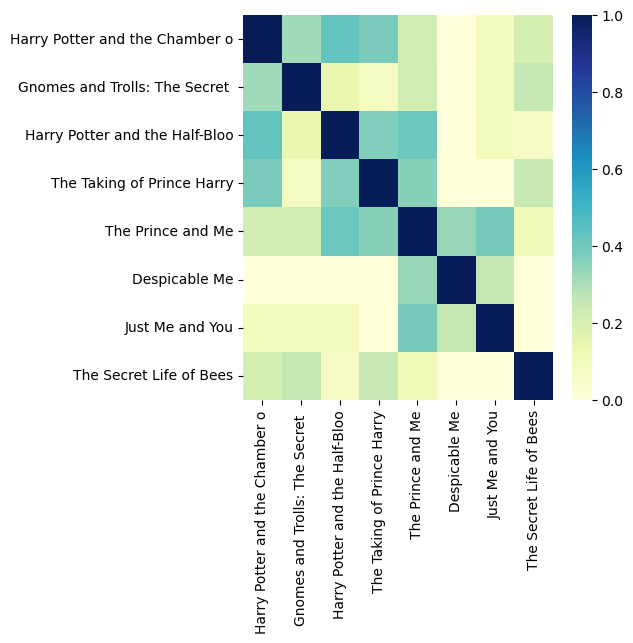

In [57]:
from sklearn.metrics.pairwise import cosine_similarity

#list1= 'Drama Mystery Fantasy Adventure'
#list2= 'Fantasy Adventure  Adventure  Epic  Fantasy  Drama  Action Sword and sorcery'
#list3= 'Satire Comedy Family'
#list4= 'Musical Drama Comedy'
#list5= 'Romantic Comedy Romance Comedy'
#list6= 'Comedy'

list1= 'Harry Potter and the Chamber of Secrets'
list2= 'Gnomes and Trolls: The Secret Chamber'
list3= 'Harry Potter and the Half-Blood Prince'
list4= 'The Taking of Prince Harry'
list5= 'The Prince and Me'
list6= 'Despicable Me'
list7= 'Just Me and You'
list8= 'The Secret Life of Bees'
headlines = [list1,list2,list3,list4,list5,list6,list7,list8]

labels = [headline[:30] for headline in headlines] 
def create_heatmap(similarity, cmap = "YlGnBu"):
  df = pd.DataFrame(similarity)
  df.columns = labels
  df.index = labels
  fig, ax = plt.subplots(figsize=(5,5))
  sns.heatmap(df, cmap=cmap)

vectorizer = sklearn.feature_extraction.text.TfidfVectorizer()
X = vectorizer.fit_transform(headlines)
#print(vectorizer.get_feature_names())
list_vectors = X.toarray()
print("Example cosine similarities between 8 movie titles: \n",cosine_similarity(list_vectors))
create_heatmap(cosine_similarity(list_vectors))

#### GloVe algorithm
**Definition**
The `GloVe` algorithm is an opensource standford algorithm that associates similarity between words by obtaining vectors representations for words and by mapping them into a meaningful space.

**Implementation** 
We can apply soft cosine similarity computation to study similarity between texts. The matrix S from the soft cosine definition can be calculated with the library `GenSim` and using the `GloVe` algorithm. We would obtain a dataset containing a vector for all the words in our corpus and we could compute the matrix S associating a similarity matrix to all of these words. Then with the soft cosine similarity we could analyse the similarity between the documents in our corpus. 

**Movie Attribute similarity that can be studied**
- Title

In [59]:
from re import sub
from gensim.utils import simple_preprocess
import gensim.downloader as api
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.similarities import WordEmbeddingSimilarityIndex
from gensim.similarities import SparseTermSimilarityMatrix
from gensim.similarities import SoftCosineSimilarity

query= 'Harry Potter and the Chamber of Secrets'

list2= 'Gnomes and Trolls: The Secret Chamber'
list3= 'Harry Potter and the Half-Blood Prince'
list4= 'The Taking of Prince Harry'
list5= 'The Prince and Me'
list6= 'Despicable Me'
list7= 'Just Me and You'
list8= 'The Secret Life of Bees'
documents = [list2,list3,list4,list5,list6,list7,list8]
stopwords = ['the', 'and', 'are', 'a']

# From: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/soft_cosine_tutorial.ipynb
def preprocess(doc):
    # Tokenize, clean up input document string
    doc = sub(r'<img[^<>]+(>|$)', " image_token ", doc)
    doc = sub(r'<[^<>]+(>|$)', " ", doc)
    doc = sub(r'\[img_assist[^]]*?\]', " ", doc)
    doc = sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', " url_token ", doc)
    return [token for token in simple_preprocess(doc, min_len=0, max_len=float("inf")) if token not in stopwords]

# Preprocess the documents, including the query string
corpus = [preprocess(document) for document in documents]
query = preprocess(query)

In [61]:
# Load the model: this is a big file, can take a while to download and open
glove = api.load("glove-wiki-gigaword-50")    
similarity_index = WordEmbeddingSimilarityIndex(glove)

# Build the term dictionary, TF-idf model
dictionary = Dictionary(corpus+[query])
tfidf = TfidfModel(dictionary=dictionary)

# Create the term similarity matrix.  
similarity_matrix = SparseTermSimilarityMatrix(similarity_index, dictionary, tfidf)

100%|██████████| 18/18 [00:00<00:00, 97.30it/s]


In [62]:
# Compute Soft Cosine Measure between the query and the documents.
# From: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/soft_cosine_tutorial.ipynb
query_tf = tfidf[dictionary.doc2bow(query)]

index = SoftCosineSimilarity(tfidf[[dictionary.doc2bow(document) for document in corpus]],similarity_matrix)

doc_similarity_scores = index[query_tf]

# Output the sorted similarity scores and documents
sorted_indexes = np.argsort(doc_similarity_scores)[::-1]
print("Soft similarities computed between the title 'Harry Potter and the Chamber of Secrets' and the other titles:")
for idx in sorted_indexes:
    print(f'{idx} \t {doc_similarity_scores[idx]:0.3f} \t {documents[idx]}')

Soft similarities computed between the title 'Harry Potter and the Chamber of Secrets' and the other titles:
1 	 0.622 	 Harry Potter and the Half-Blood Prince
2 	 0.580 	 The Taking of Prince Harry
0 	 0.550 	 Gnomes and Trolls: The Secret Chamber
6 	 0.370 	 The Secret Life of Bees
5 	 0.000 	 Just Me and You
4 	 0.000 	 Despicable Me
3 	 0.000 	 The Prince and Me


/Users/camilleguillaume/opt/anaconda3/envs/ada/lib/python3.9/site-packages/gensim/similarities/termsim.py:382: RuntimeWarning: divide by zero encountered in divide
  normalized_corpus = np.multiply(corpus, 1.0 / corpus_norm)
/Users/camilleguillaume/opt/anaconda3/envs/ada/lib/python3.9/site-packages/gensim/similarities/termsim.py:382: RuntimeWarning: invalid value encountered in multiply
  normalized_corpus = np.multiply(corpus, 1.0 / corpus_norm)


### 3. Topic extraction method
To compare plots, we will use a topic extraction algorithm. There are a lot that exist, but we will concentrate on three possible: LDA, Doc2Vec and BERTopic.

#### Preprocessing method on a document corpus before topic extraction

Here is a preprocessing approach that can be implemented before using a topic extraction analysis
1. Removing the stop words from the documents which are the most common words occuring in texts that give no additional concept. It can be done with `Java` using `MySQL`.
2. Removing the numbers appart from years, the non-asci characters, and most common occuring names (ex: James, Robert, John)
3. Handle pural and singular form of the same word by lemmatizing.
4. We can filter the words using tf-idf. We can compute the tf-idf for each word of each plot and keep the words with highest tf-idf score. The threshold for a word to be kept has to be defined.

#### LDA: Latent Dirichlet Allocation

<div>
<img src="images/LDA_example.png" width="800"/>
</div>

**Definition**

LDA is an algorithm that can be used for topic extraction in texts. It is an unsupervised machine-learning model that takes documents as input and finds topics as output. A topic is represented as a weighted list of words. The model also says in what percentage each document talks about each topic. 

**Implementation**

LDA can be implemented using the `GenSim` library. When using LDA to analyse topics in a corpus, it needs some preprocessing steps before applying the algorithm to make it more efficient. We detailed one preprocessing approach above.


After this processing we can apply LDA on our database by tuning some parameters:
<br>
$K$: the number of topics we look for
<br>
$\alpha$: K-dimension vector of positive reals that represent the prior weights of topic K in a document which affects the document-topic distribution. 
<br>
$\eta$: V-dimension vector of positive reals that represents the prior weights of each words in topics which affects the topic-word distribution

If we chose a symetric LDA, the weights $\alpha$ would be the same for all topics and the weights $\eta$ would be the same for all words in a topic. The smaller the $\alpha$ the fewer topics per document, the fewer the $\eta$ the fewer words per topic.

#### Doc2Vec topic extraction
**Definition**

Doc2Vec is an unsupervised algorithm that learns fixed-length feature vectors for paragraphs/documents/texts. Then we can compare these vectors to assess the similarity between documents. Doc2vec allows to generate a semantic space which is a spatial space where distance among vectors are indicator of semantic similarity. This semantic space consisting of word and document vectors is a continuous representation of topics, unlike LDA where topics are sampled from a discrete space. It means that the dense areas having high concentration of document can be thought of having similar topics and can be best represented by nearby embedded words.

**Implementation**

It can be implemented using the `GenSim` library with the class `Doc2Vec` that extends the class `Word2Vec`. 

#### BERTopic

<div>
<img src="images/BERTopic.png" width="600"/>
</div>

**Definition**
BERTopic is a guided semi-supervised topic modeling algorithm. Contrary to LDA, it uses embeddings (thus semi-supervised) and class-based tf-idf (ctf-idf) to find easily interpretable topics and makes it more stable to small variations. It works in three stages:

- Embed the documents
- Cluster the documents
- Create a list of topics and their representation

With this algorithm it is possible to find a list of topics and also give the probability of each topic in each document.

**Implementation**

BERTopic can be implemented using the python `BerTopic` library. As with LDA, we can preprocess the documents (plots in our case) before giving it to the BERTopic for better results.

Each stage of the BERTopic can be parameterized to get better results:
<br>
$Embedding$: by default it uses the `paraphrase-MiniLM-L6-v2` sentence transformers, but we can use any other embedding technique.
<br>
$Clustering$: by default it uses HDBSCAN (hierarchical DBSCAN) to cluster the documents, but to apply this efficiently UMAP is used to reduce the dimensionality of the embeddings. It is possible to change the dimension reduction algorithm and the clustering algorithm, for example we could import K-means form `sklearn.cluster` and use that.
<br>
$Topic$ $representation$: by default it uses class-based tf-idf, meaning it adjusts the tf-idf inside each class (cluster) in relation with the frequency of a word inside the class. Here again it can be tuned for example to try to show different representatives of a cluster. This can be useful to avoid having "bycycle", "cycling" and "bike" as the representatives of a cluster, where only one of them would have been enough.

#### Computation of similarity from topic extraction

Regardless of the method of analysis of the plot, we can have a vector representation at the end:
- Doc2Vec gives a vector directly
- LDA gives the freqency of each topic per document. We can build a vector for each document where each element represents a topic, and it will be proportional to the frequency of the topic.
- BERTopic gives a probability of each topic per document. Similarly to LDA we can build a vector where each element is a topic and fill it with the corresponding probability.

We can then compare these vectors using the cosine similarity for example.

### 4. Tuning the weights using sequels

How to tell if our similarity function between two movies is working well? First of all, we can't say it for sure, since it is a subjective question. However usually we can still agree on these points:

* Movies that are part of a sequel should have a high similarity
* Movies with completely different genres should have a low similarity (for exmaple one is a "Adventure/Aciton" movie and the other a "Romantic Comedy")

Hence we can build two datasets, one of pairs of movies we expect to have a high similarity and the other of pairs of movies we expect to have low similarity. We can then use these datasets to assess if our similarity function is giving the "right" values.

**Movies from sequels**

Before creating pairs of movies that are similar we should group movies by sequels. Unfortunately, we don't have this data directly accessible in our dataset, but by using the name.clusters.txt file we can have characters that are re-used. It doesn't necesseraly mean that the movie is a sequel (for example with Sherlock Holmes it can be the another representation of him playing), but we still expect these movies to be similar.

First, using the `df_char` dataframe from character.metadata.tsv and the `freeID_char_map` given for each character, we find the unique `WikiID` movie in which the character is played.

In [41]:
df_char_names["WikiID"] = [ df_char[df_char['freeID_char_map'] == x]["WikiID"].item() for x in df_char_names["freeID_char_map"]]

Then we group all characters together, so for each character we have a list of movies in which he played (represented by their WikiID).

In [42]:
df_char_grouped = df_char_names.groupby("char_name")["WikiID"].apply(set).to_frame()
df_char_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 970 entries, 'Baby' Louise to Zack Martin
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   WikiID  970 non-null    object
dtypes: object(1)
memory usage: 15.2+ KB


We could stop here, but right now we still have repetitions: for example Harry Potter and Hermione Granger will appear in the same movies, it would be good to group them together to have a list of separate sequels. However we will have a problem: what to do if only some actors repeat? For example if we take "The Lord of the Rings" and "The Hobbit", Gandalf will appear in both, Aragorn only in "The Lord of the Rings" and Thorin Oakenshield only in "The Hobbit". In our case, we will assume if some characters repeat in these sequels and others don't, it's still highly likely very similar movies, so we will group them all together.

In other words, we group the movies together until we have disjoint movie sets.

Because the list of grouped characters isn't that big (970 rows), we can work with python lists instead of the panda dataframe. We create a list of movie sets (each element of the list comes from one character):

In [43]:
starting_list = []
# Iterate over each row
for index, rows in df_char_grouped.iterrows():
    # append the list to the final list
    starting_list.append(rows["WikiID"])

Then we join the movies sets from different characters if they both appear in at least one same movie. To do it, we create an empty list, and then iteratively check if we should append a new set (if it has no intersection with the previously added) or make a union with an already existing set (if there is an intersection). To assure that the sets are completely disjoint we run this merging algorithm until the starting "individual" list has the same lenght as the "joined" list.

In [44]:
joined_characters = []
same = False

while not(same):    
    for i in starting_list:
        joined = False
        for j in range(len(joined_characters)):
            if joined_characters[j] & i: #there is an intersection in the sets
                joined_characters[j] = joined_characters[j] | i #the union of both sets
                joined = True
        if joined == False:
            joined_characters.append(i)
    
    if len(starting_list) == len(joined_characters):
        same = True
    else:
        starting_list = joined_characters
        joined_characters = []

print(len(joined_characters))

583


We get 583 different sequels, which will be enough to test for similarities. To actually compute a similarity we will need to choose a sequel, and then choose a pair of movies in this sequel. If a sequel has n movies in it, the number of different pairs we can build is n*(n-1)/2. If we compute this for all sequels, we find that we can have 10929 different possible pairs:

In [45]:
sum_pairs = 0
for i in joined_characters:
    n = len(i)
    sum_pairs = sum_pairs + n*(n-1)/2

print(sum_pairs, "different possible pairs")

10929.0 different possible pairs


**Movies with different genres**

For this milestone we didn't built a dataset of pairs of movies with different genres, because we're confident it won't be a problem to find them. Building a dataset also won't be a problem: you sample a movie randomly, and then sample another one to form a pair. If the second one has an intersection in the genres, you resample it, until you find one with 0 intersection. We won't create all possible pairs because the dataset will be too large.

**Conclusion**

With this two datasets we will be able to test our similarity function, and possibly adjust its values to have a high similarity in sequels and low similarity in movies from completely different genres. We will also need to be careful to not base the tuning completely on this as by the construction of the datasets it will give a high importance to similar characters and genres.

---
## Visualization method

We want to be able to visualize our graph. But how do you represent a graph? You could start by placing one node, and then place its neighbours at a distance (or 1/similarity) around him, then place their neighbours and so on. But with that method you can have a problem of not respecting distances with already 3 nodes A, B and C: for example the distance AB = BC = 1 and distance AC = 10. It means we probably won't be able to represent the graph perfectly, but we can still try to do the best possible by plotting nodes with a high similarity close to each other and those with a low similarity far from each other. This is done using Graph Layout Algorithms.

### Gephi

<div>
<img src="images/gephi.jpg" width="600"/>
</div>

**Definition**

Gephi is an "open-source platform for visualizing and manipulating large graphs". Their Graph Layout Algorithm is force based, meaning nodes will repell and attract each other in function of the distance between them, and the visualization is in the equilibrium state.
 

**Implementation**

We found a [github repository](https://github.com/la-rana-kermit/Gephi-python-module) to interface Gephi with Python, which is what we'll try to use to implement. However this repository doesn't seem very active, so if we get some problems we might switch to the Gephi Software directly.


---

## Annexe: Mathematical definitions related to similarity

#### 1.1 Cosine similarity
$$
cosine \: similarity(A,B)=S_c(A,B)=cos(\theta)=\frac{A \cdot B}{\|A\| \|B\|}=\frac{\sum_{i=1}^{n}A_iB_i}{\sqrt{\sum_{i=1}^{n} A_i^2}\sqrt{\sum_{i=1}^{n} B_i^2}}
$$
Where $A,B \in \mathbb{R}^n$, $S_c(A,B) \in [-1,1]$ where -1 means that the two vectors are exactly opposite, and 1 means that they are exactly similar and 0 means that they are orthognonal which shows decorrelation.

#### 1.2 Centered Cosine similarity
$$
centered \: cosine \: similarity(A,B)=\frac{(A-\overline{A}) \cdot (B-\overline{B})}{\|A-\overline{A}\| \|B-\overline{B}\|}
$$
Where A and B have been normalized before by substracting their mean.

#### 1.3 Soft cosine similarity
$$
soft \: cosine \: similarity(A,B)=\frac{\sum_{i,j}^{n}s_{ij}A_iB_j}{\sqrt{\sum_{i,j}^{n} s_{ij}A_iA_j}\sqrt{\sum_{i,j}^{n} s_{ij}B_iB_j}}
$$
where $s_{ij}$=similarity($feature_i$,$feature_j$). For example if $s_{ii}$=1 and $s_{ij}$=0 $\forall i\neq j$ then there is no similarity between features, then the soft cosine similarity is equal to the cosine similarity. In the case where features are words, the matrix $S$ has to define the similarity between words.

#### 1.4 Associated distance with cosine similarity
- **Angular distance**

if $A_i,B_i \in \mathbb{R}$ 
$$
angular \: distance=D_\theta=\frac{arccos(S_c(A,B))}{\pi}=\frac{\theta}{\pi}
$$
$$
angular \: similarity=S_\theta=1-D_\theta=1-\frac{\theta}{\pi}
$$
if $A_i,B_i \in \mathbb{R}$ and $A_i,B_i\geq 0$
$$
angular \: distance=D_\theta=\frac{2 \cdot \textrm{arccos}(S_c(A,B))}{\pi}=\frac{2\theta}{\pi}
$$
$$
angular \: similarity=S_\theta=1-D_\theta=1-\frac{2\theta}{\pi}
$$
Where the angular distacne is a formal distance metric, however the arccos computation cost makes it more computationally expensive and slower.

- **Cosine distance**

$$
cosine \: distance=D_c=1-S_c(A,B)
$$
Where the cosine distance is an unformal distance metric (it does not respect the triangle inequality or Schwarz inequality) but it is less computationally expensive.


- **L2-normalized Euclidean distance**

From the L2 distance defined as followed: $ \|x\|_2=\sqrt{\sum x_i^2}=\sqrt{x.x} $ and the euclidean distance defined as followed: 
$ d(A,B)=|A-B|=\sqrt{\sum _{i=1}^{n} (A_i-B_i)^2 } $, we get the L2-normalized Euclidean distance:
$$
L2-normalized \: Euclidean \: distance=\sqrt{\sum _{i=1}^{n} (A_i'-B_i')^2} \quad \textrm{where} \quad A'=\frac{A}{\|A\|_2}
$$

The cosine similarity and associated distances reflects relative rather than absolute comparison of vectors. For example vectors $A$ and $\alpha A$ where $\alpha \in \mathbb{R}$ are maximally similar. Therefore this similarity is appropriate for data where frequency is more important than absolute value. For text comparison it can be very useful, we could compare the frequency of terms in a document.  

#### 1.5 Jaccard similarity coefficient

$$
J(A,B) = \frac{|A \cap B|}{|A \cup B|} = \frac{|A \cap B|}{|A| + |B| - |A \cap B|}
$$
where $J(A,B) \in [0,1]$.
It measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets.  

#### 1.6 Associated distance with Jaccard similarity
$$
d_J(A,B)=1-J(A,B)=\frac{|A\cup B|-|A\cap B|}{|A\cup B|}
$$
The Jaccard distance, which measures dissimilarity between sample sets, is complementary to the Jaccard coefficient and is obtained by subtracting the Jaccard coefficient from 1, or, equivalently, by dividing the difference of the sizes of the union and the intersection of two sets by the size of the union.